Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,ConfusionMatrixDisplay,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression


Importing Dataset and Data Cleaning

In [15]:
base_df = pd.read_csv("dataset_phishing.csv")
print(base_df.head())

                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                

In [16]:
# Checking for missing values and dropping duplicates:
print("Missing Values:\n", base_df.isnull().sum())
print("No missing values found")
base_df = base_df.drop_duplicates()

Missing Values:
 url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64
No missing values found


In [17]:
# Dropping Extra/Unusable/Excess 0s Columns:
dropped_columns = ["length_url","nb_and","nb_or","nb_tilde","nb_percent","nb_star","nb_colon","nb_comma","nb_semicolumn","nb_dollar","nb_space","ratio_digits_url","ratio_digits_host","nb_dslash","punycode","port","tld_in_path","tld_in_subdomain","abnormal_subdomain","path_extension","nb_external_redirection","brand_in_subdomain","brand_in_path","suspecious_tld","statistical_report","nb_hyperlinks","ratio_nullHyperlinks","nb_extCSS","ratio_intRedirection","ratio_intErrors","submit_email","sfh","iframe","popup_window","onmouseover","right_clic","dns_record","login_form","whois_registered_domain","shortest_words_raw","shortest_word_path","longest_words_raw","longest_word_host","longest_word_path"]
print(f"Number of Columns dropped: {len(dropped_columns)}")
reduced_df = base_df.drop(columns=dropped_columns)
print(f"Primarily Reduced Dataframe Shape: Rows = {reduced_df.shape[0]} Columns = {reduced_df.shape[1]}")

Number of Columns dropped: 44
Primarily Reduced Dataframe Shape: Rows = 11430 Columns = 45


In [18]:
# Selecting numerical values and dropping any outliers:
numerical_cols = reduced_df.select_dtypes(include=np.number).columns

reduced_df[numerical_cols] = reduced_df[numerical_cols].fillna(reduced_df[numerical_cols].mean())
# Selecting numerical columns that have more than 20 unique values
non_binary_cols = [col for col in numerical_cols if reduced_df[col].nunique() > 20]

# Remove outliers for non-binary numerical columns
Q1 = reduced_df[non_binary_cols].quantile(0.25)
Q3 = reduced_df[non_binary_cols].quantile(0.75)
IQR = Q3 - Q1

prim_cleaned_df = reduced_df[~((reduced_df[non_binary_cols] < (Q1 - 1.5 * IQR)) | (reduced_df[non_binary_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


print("Cleaned Data:\n", prim_cleaned_df.describe())

Cleaned Data:
        length_hostname           ip      nb_dots   nb_hyphens        nb_at  \
count      3279.000000  3279.000000  3279.000000  3279.000000  3279.000000   
mean         18.558707     0.082037     2.418725     0.381824     0.021958   
std           6.244178     0.274463     0.956671     0.630222     0.166083   
min           4.000000     0.000000     1.000000     0.000000     0.000000   
25%          14.000000     0.000000     2.000000     0.000000     0.000000   
50%          18.000000     0.000000     2.000000     0.000000     0.000000   
75%          22.000000     0.000000     3.000000     1.000000     0.000000   
max          37.000000     1.000000     8.000000     2.000000     4.000000   

             nb_qm        nb_eq  nb_underscore     nb_slash       nb_www  ...  \
count  3279.000000  3279.000000    3279.000000  3279.000000  3279.000000  ...   
mean      0.096676     0.126868       0.240622     4.034767     0.465386  ...   
std       0.300677     0.481260       0

Exploratory Data Analysis: Graphs and Summary Statistics

In [19]:
# Calculating Summary Statistics of Numerical Columns:
summary = {
    'Mean': prim_cleaned_df[numerical_cols].mean(),
    'Median': prim_cleaned_df[numerical_cols].median(),
    'StDev': prim_cleaned_df[numerical_cols].std(),
    'CV': prim_cleaned_df[numerical_cols].std() / prim_cleaned_df[numerical_cols].mean(),
    'Q1': prim_cleaned_df[numerical_cols].quantile(0.25),
    'Q3': prim_cleaned_df[numerical_cols].quantile(0.75),
    'Min': prim_cleaned_df[numerical_cols].min(),
    'Max': prim_cleaned_df[numerical_cols].max()
}
# Convert summary into a DataFrame for better readability
summary_df = pd.DataFrame(summary)
print("Summary Statistics:\n", summary_df)

Summary Statistics:
                                     Mean       Median          StDev  \
length_hostname                18.558707    18.000000       6.244178   
ip                              0.082037     0.000000       0.274463   
nb_dots                         2.418725     2.000000       0.956671   
nb_hyphens                      0.381824     0.000000       0.630222   
nb_at                           0.021958     0.000000       0.166083   
nb_qm                           0.096676     0.000000       0.300677   
nb_eq                           0.126868     0.000000       0.481260   
nb_underscore                   0.240622     0.000000       0.888739   
nb_slash                        4.034767     4.000000       1.377944   
nb_www                          0.465386     0.000000       0.500708   
nb_com                          0.067704     0.000000       0.273371   
http_in_path                    0.008539     0.000000       0.092026   
https_token                     0.623056   

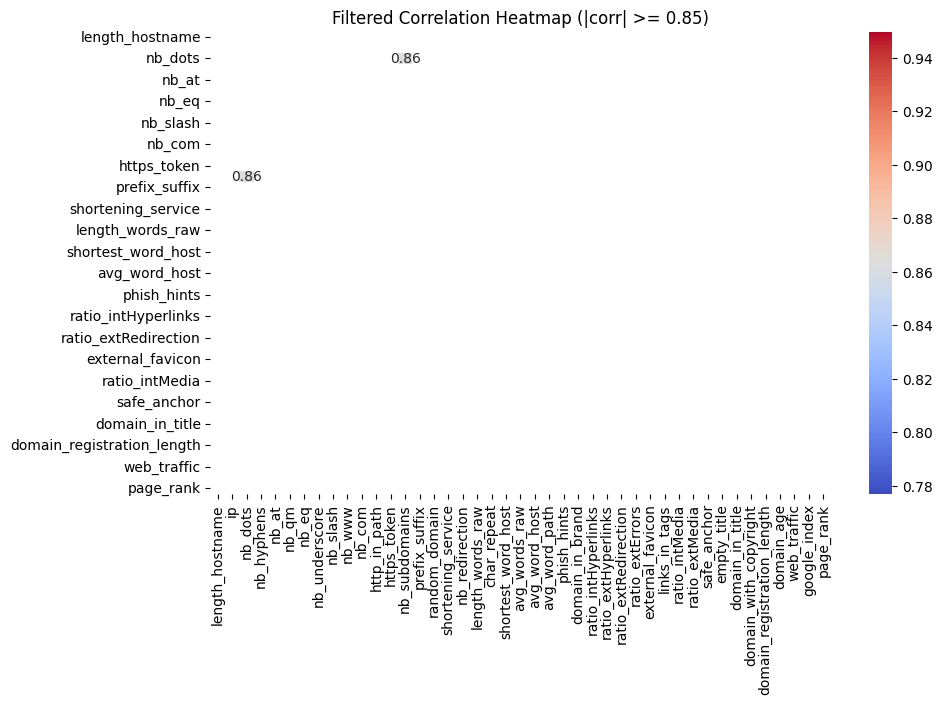

Top correlations for length_hostname:
length_hostname    1.000000
avg_word_host      0.564300
avg_words_raw      0.398506
nb_dots            0.342920
nb_subdomains      0.335738
Name: length_hostname, dtype: float64

Top correlations for ip:
ip                  1.000000
length_words_raw    0.359953
nb_eq               0.297637
avg_word_path       0.257742
nb_qm               0.214383
Name: ip, dtype: float64

Top correlations for nb_dots:
nb_dots             1.000000
nb_subdomains       0.863383
length_words_raw    0.553077
length_hostname     0.342920
char_repeat         0.239830
Name: nb_dots, dtype: float64

Top correlations for nb_hyphens:
nb_hyphens          1.000000
prefix_suffix       0.598308
length_words_raw    0.318661
phish_hints         0.230621
nb_slash            0.211642
Name: nb_hyphens, dtype: float64

Top correlations for nb_at:
nb_at               1.000000
nb_qm               0.305687
nb_com              0.289765
nb_dots             0.207076
length_words_raw    0.196

In [20]:
# Correlation Heatmap:
threshold = 0.85 # filter threshold
correlation_matrix = prim_cleaned_df[numerical_cols].corr()
strong_corr = correlation_matrix[(np.abs(correlation_matrix) >= threshold) & (correlation_matrix != 1.0)]

# Plot filtered heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm', mask=strong_corr.isnull())
plt.title("Filtered Correlation Heatmap (|corr| >= 0.85)")
plt.show()

# Iterate over numerical columns and show their top correlations
for col in prim_cleaned_df[numerical_cols]:
    top_corrs = correlation_matrix[col].sort_values(ascending=False).head(5)
    print(f"Top correlations for {col}:\n{top_corrs}\n")

As we can see from the above graph, there is a high correlation between nb_dots and nb_subdomains(0.86)


We decided to drop nb_subdomains to reduce correlation.

In [21]:
# Re initializing and Dropping decided Columns:
dropped_columns = ["length_url","nb_and","nb_or","nb_tilde","nb_percent","nb_star","nb_colon","nb_comma","nb_semicolumn","nb_dollar","nb_space","ratio_digits_url","ratio_digits_host","nb_dslash","punycode","port","tld_in_path","tld_in_subdomain","abnormal_subdomain","path_extension","nb_external_redirection","brand_in_subdomain","brand_in_path","suspecious_tld","statistical_report","nb_hyperlinks","ratio_nullHyperlinks","nb_extCSS","ratio_intRedirection","ratio_intErrors","submit_email","sfh","iframe","popup_window","onmouseover","right_clic","dns_record","login_form","whois_registered_domain","shortest_words_raw","shortest_word_path","longest_words_raw","longest_word_host","longest_word_path"]
dropped_columns = dropped_columns + ["nb_subdomains"]

print(f"Number of Columns dropped: {len(dropped_columns)}")
reduced_df = base_df.drop(columns=dropped_columns)
print(f"Reduced Dataframe Shape: Rows = {reduced_df.shape[0]} Columns = {reduced_df.shape[1]}")

# Selecting numerical values and dropping any outliers:
numerical_cols = reduced_df.select_dtypes(include=np.number).columns
# Identify numerical columns that have more than 20 unique values
non_binary_cols = [col for col in numerical_cols if reduced_df[col].nunique() > 20]

# Remove outliers for non-binary numerical columns
Q1 = reduced_df[non_binary_cols].quantile(0.25)
Q3 = reduced_df[non_binary_cols].quantile(0.75)
IQR = Q3 - Q1


prim_cleaned_df = reduced_df[~((reduced_df[non_binary_cols] < (Q1 - 1.5 * IQR)) | (reduced_df[non_binary_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Cleaned Data:\n", prim_cleaned_df.describe())


Number of Columns dropped: 45
Reduced Dataframe Shape: Rows = 11430 Columns = 44
Cleaned Data:
        length_hostname           ip      nb_dots   nb_hyphens        nb_at  \
count      3279.000000  3279.000000  3279.000000  3279.000000  3279.000000   
mean         18.558707     0.082037     2.418725     0.381824     0.021958   
std           6.244178     0.274463     0.956671     0.630222     0.166083   
min           4.000000     0.000000     1.000000     0.000000     0.000000   
25%          14.000000     0.000000     2.000000     0.000000     0.000000   
50%          18.000000     0.000000     2.000000     0.000000     0.000000   
75%          22.000000     0.000000     3.000000     1.000000     0.000000   
max          37.000000     1.000000     8.000000     2.000000     4.000000   

             nb_qm        nb_eq  nb_underscore     nb_slash       nb_www  ...  \
count  3279.000000  3279.000000    3279.000000  3279.000000  3279.000000  ...   
mean      0.096676     0.126868       0

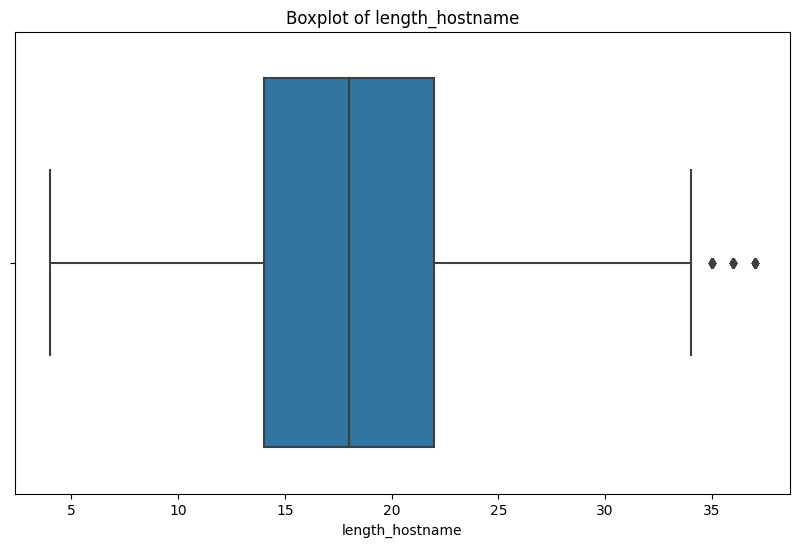

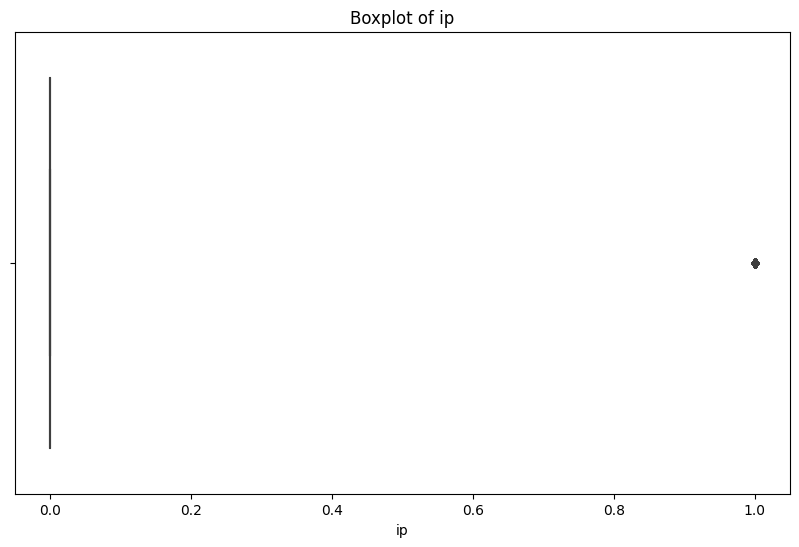

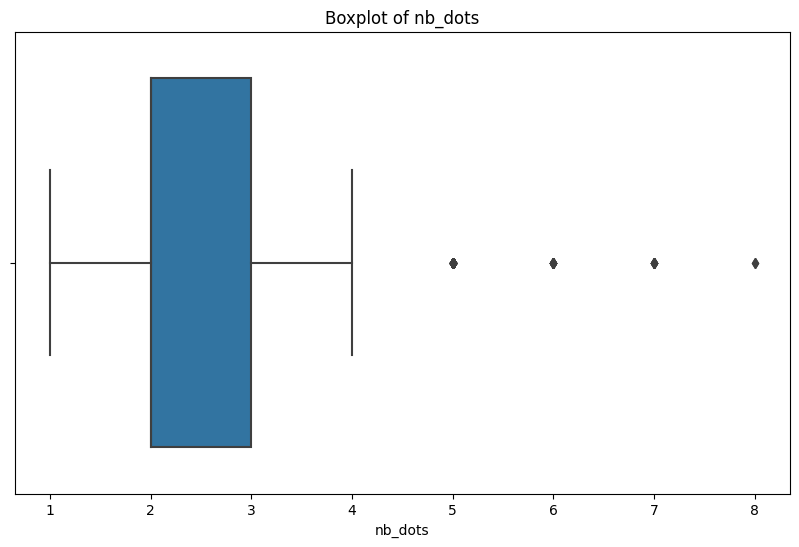

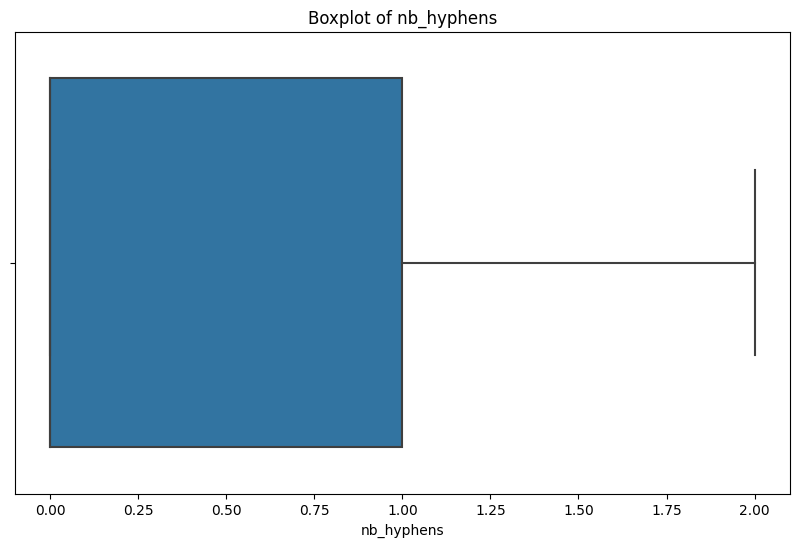

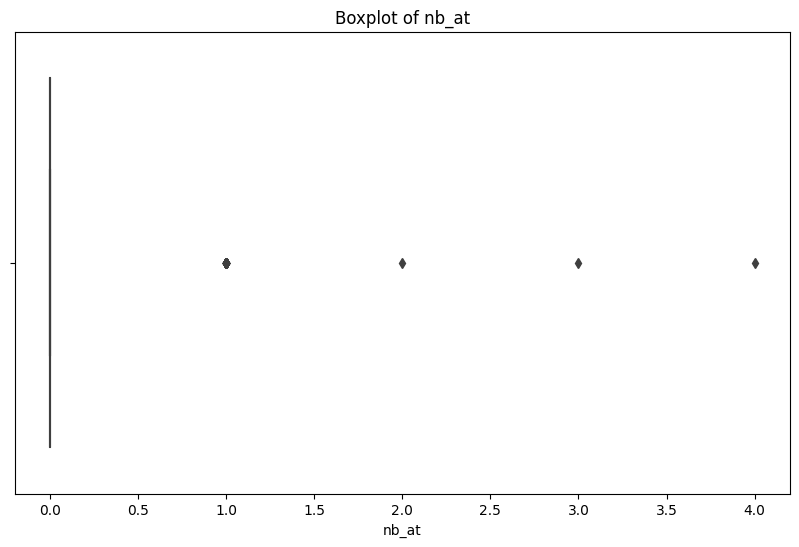

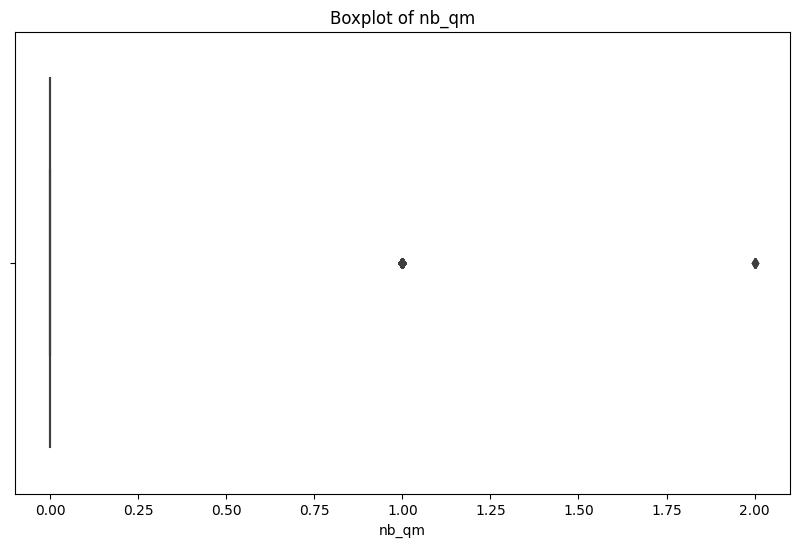

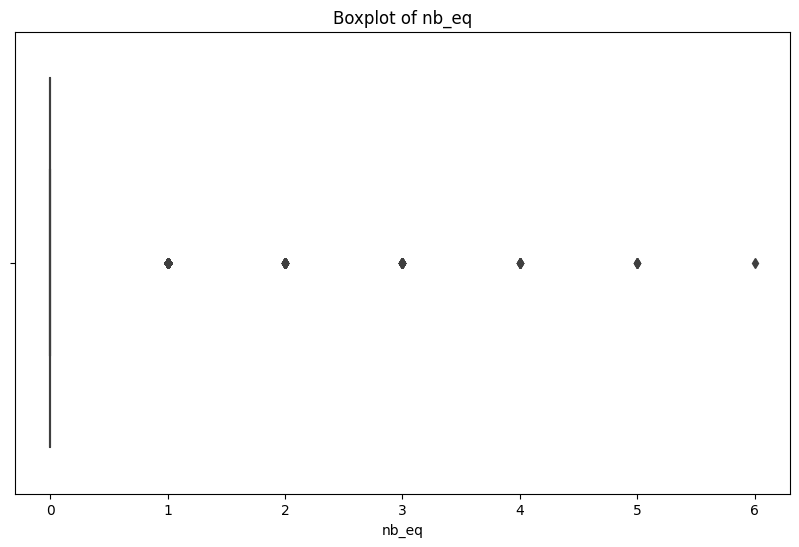

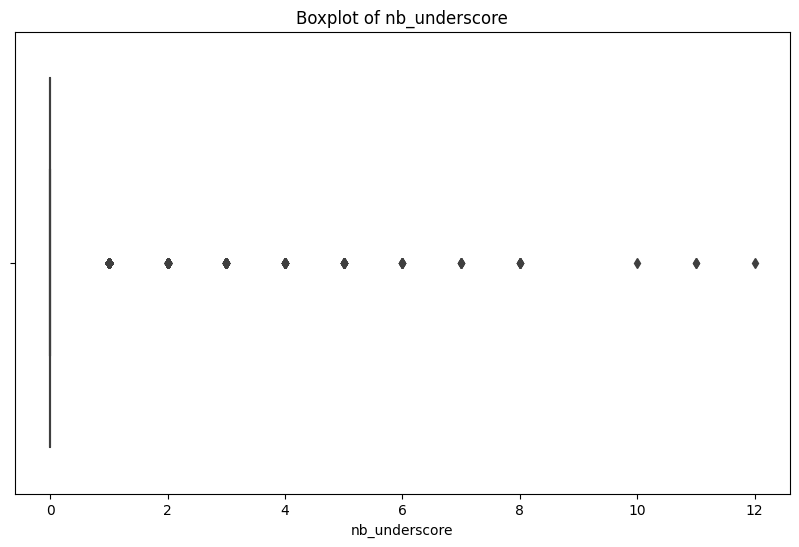

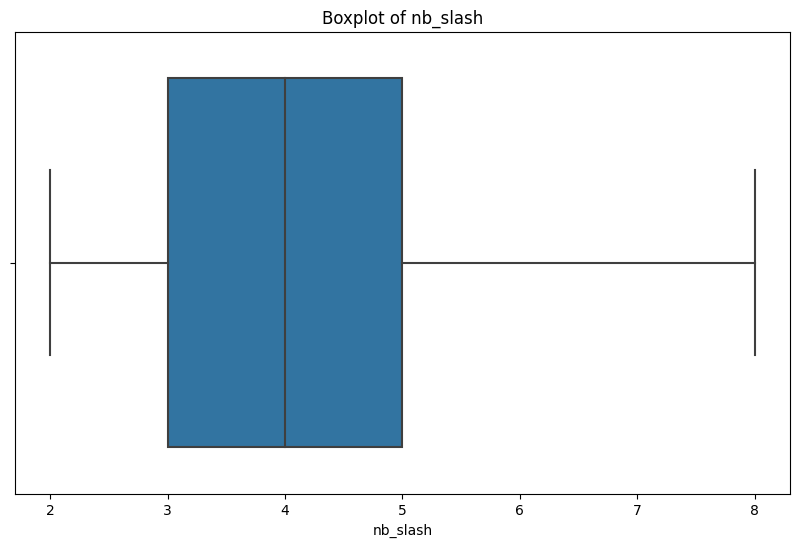

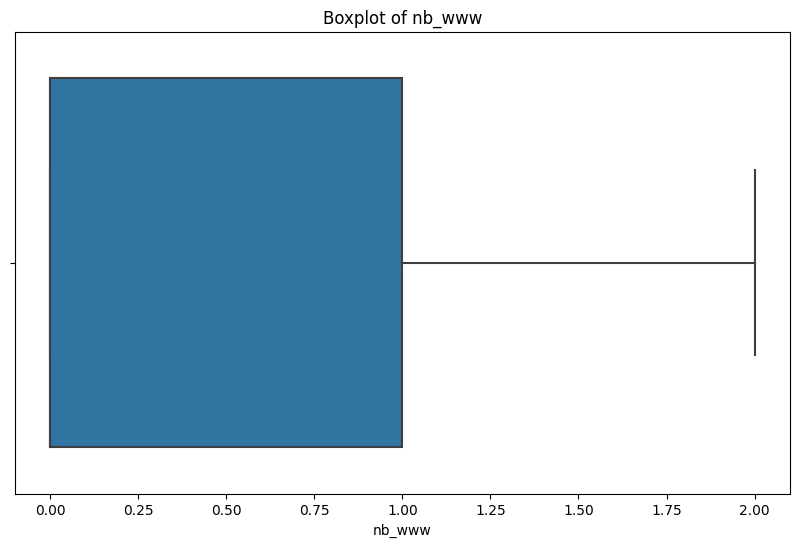

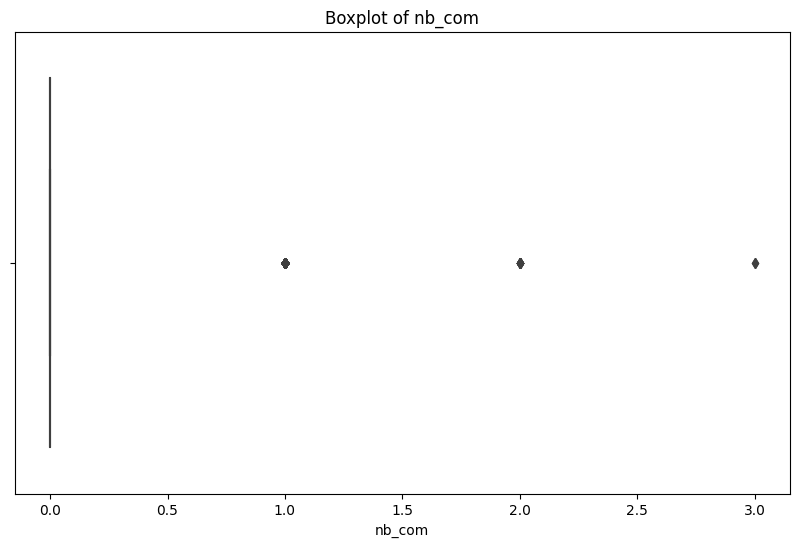

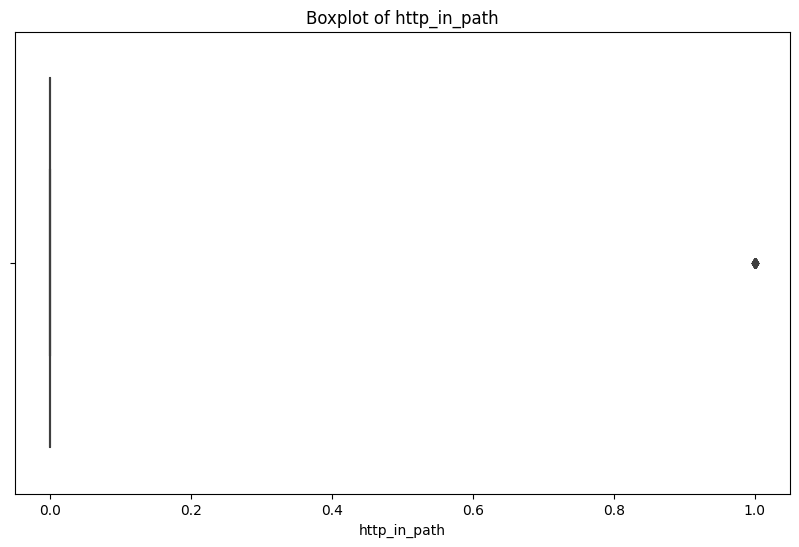

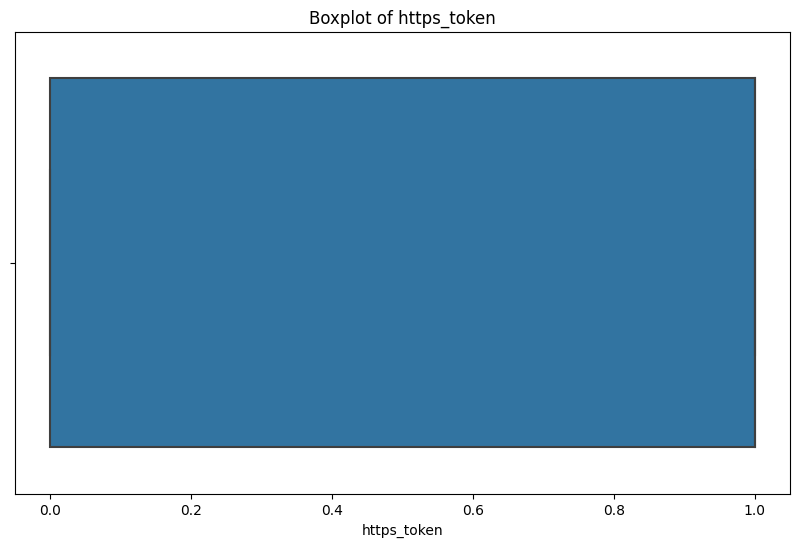

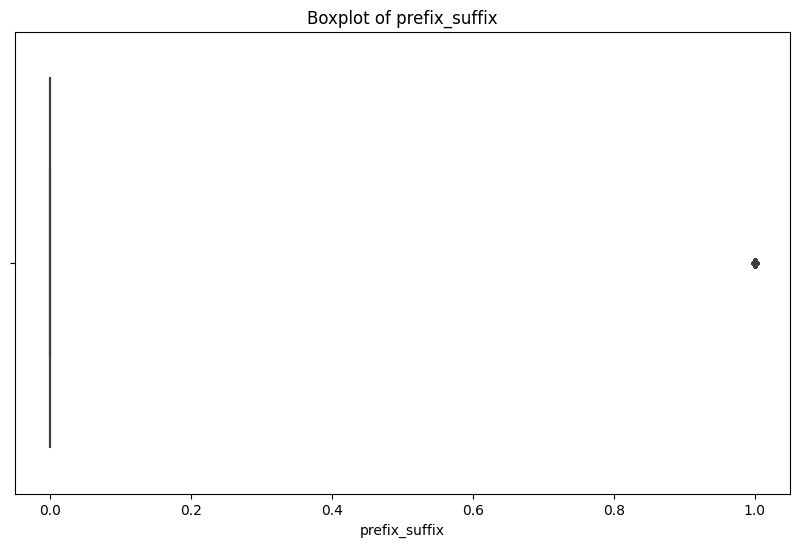

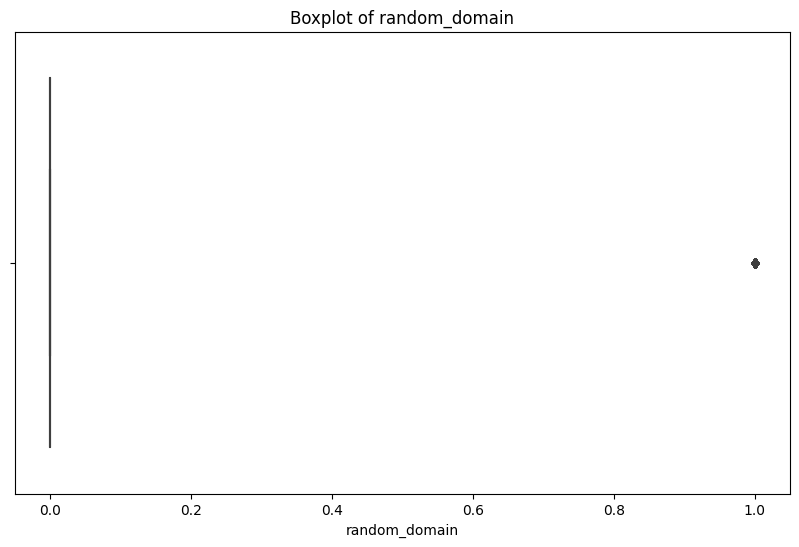

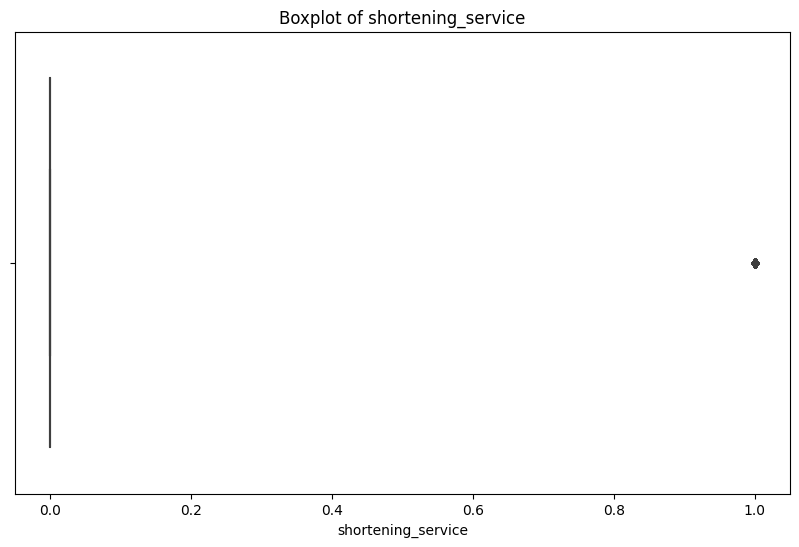

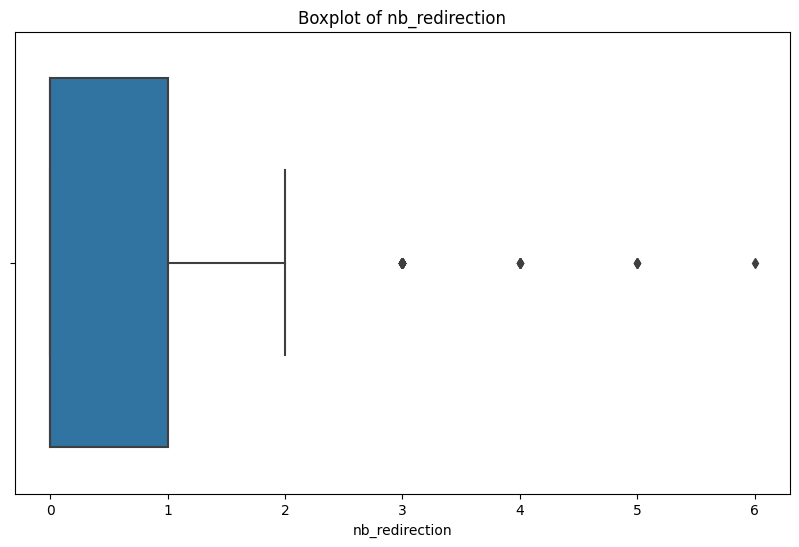

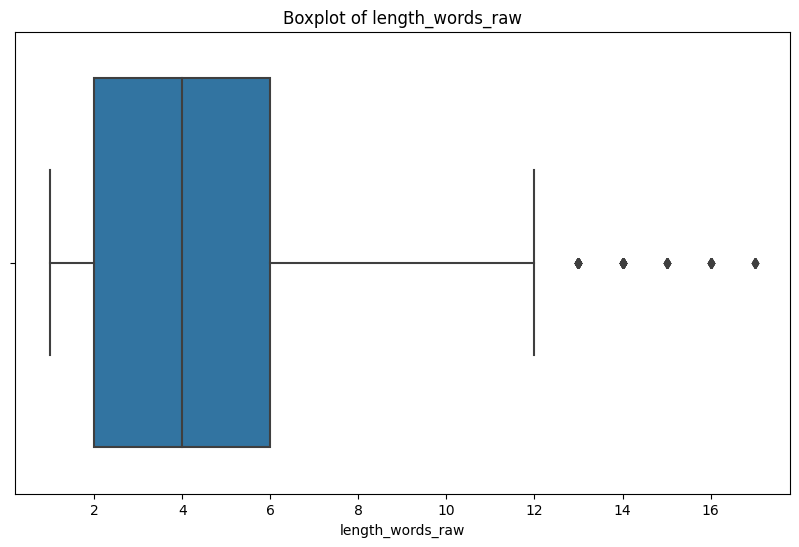

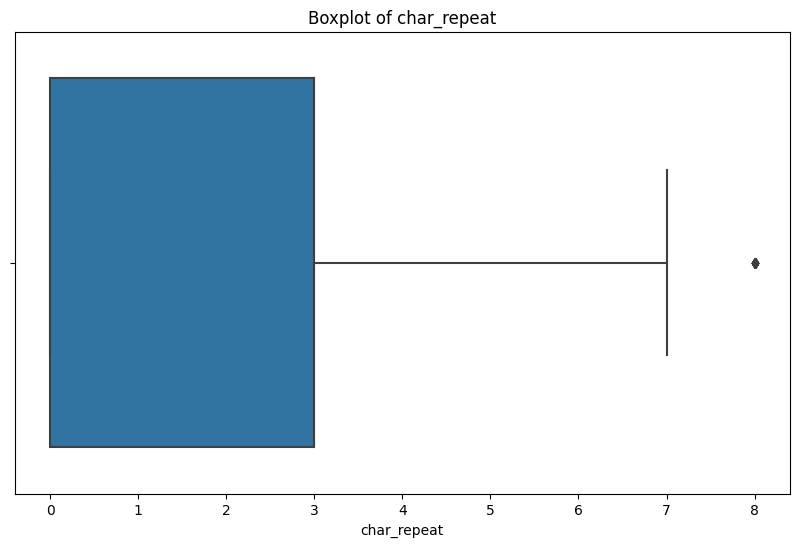

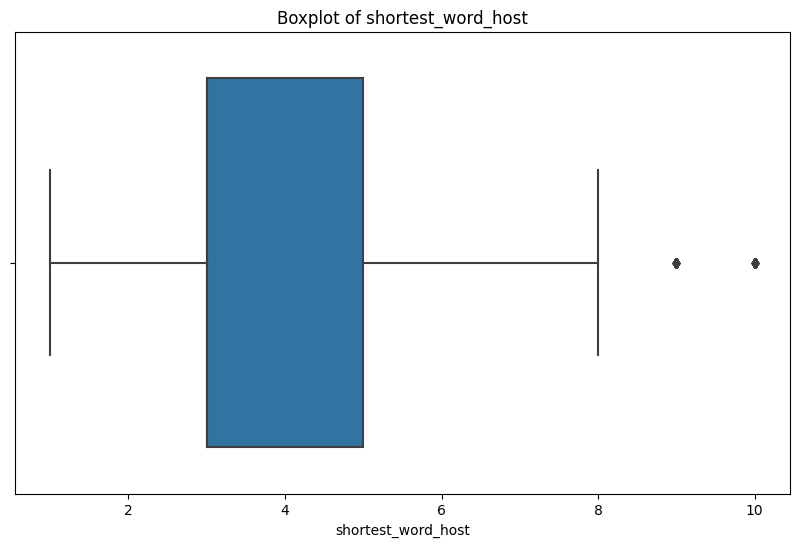

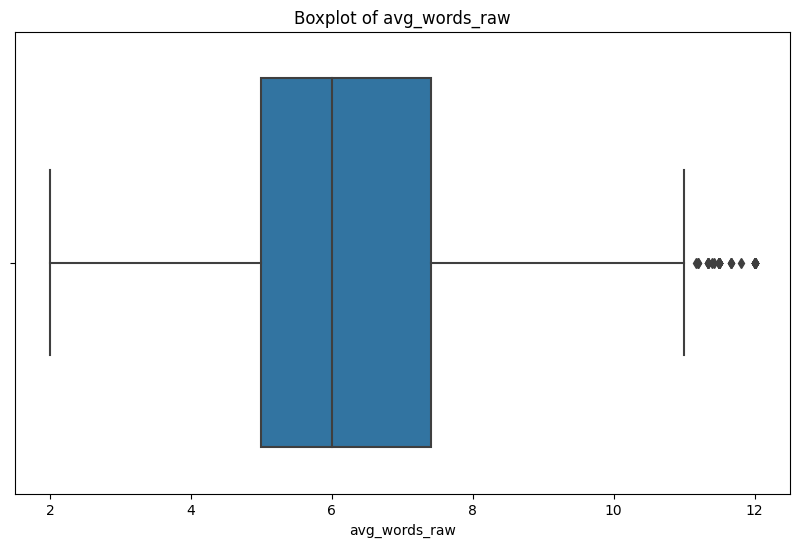

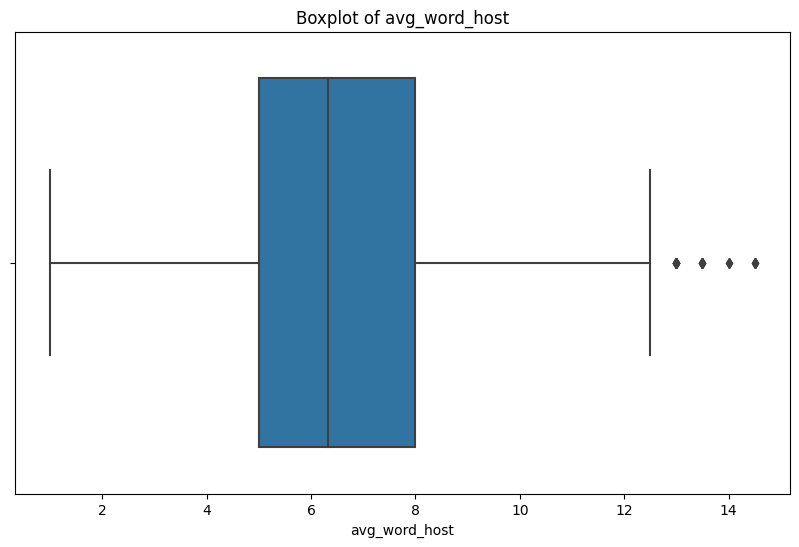

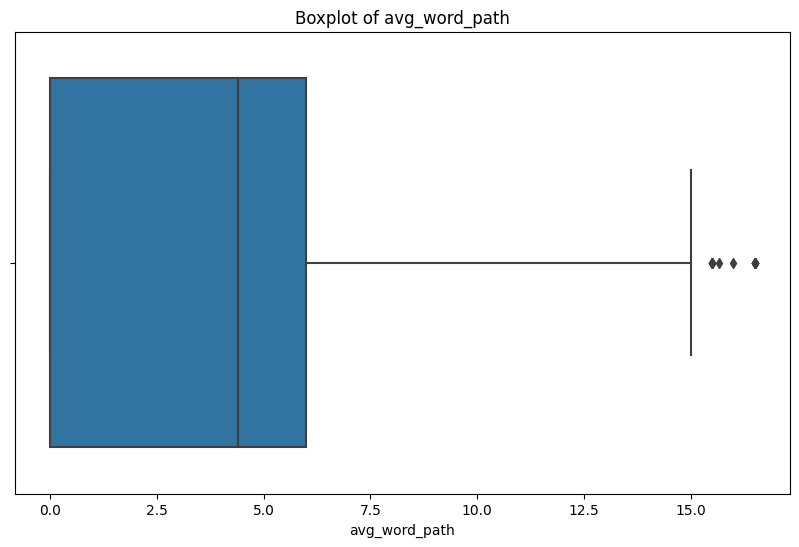

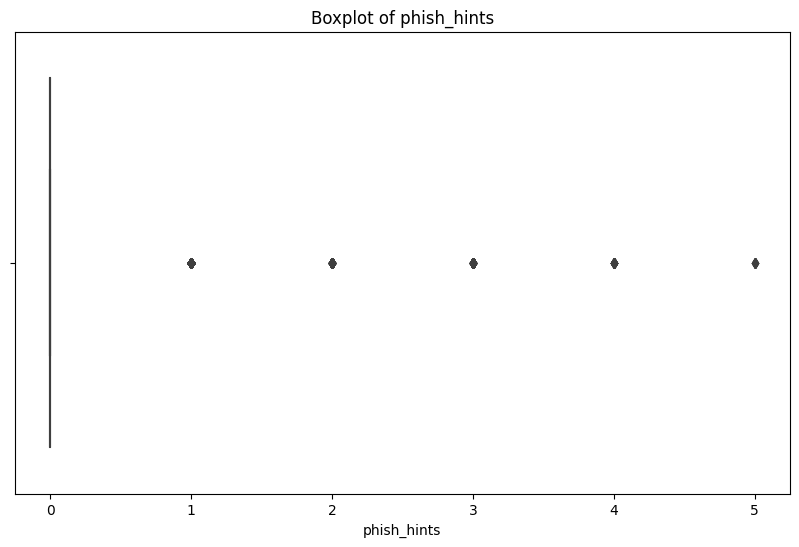

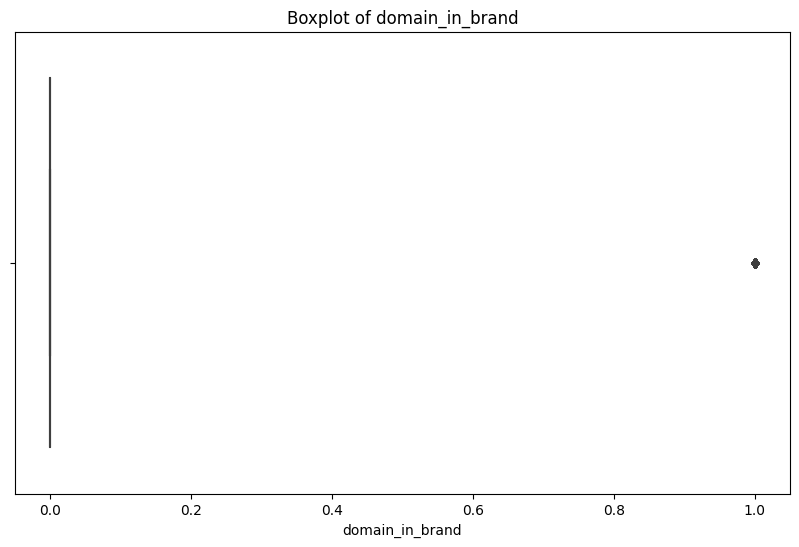

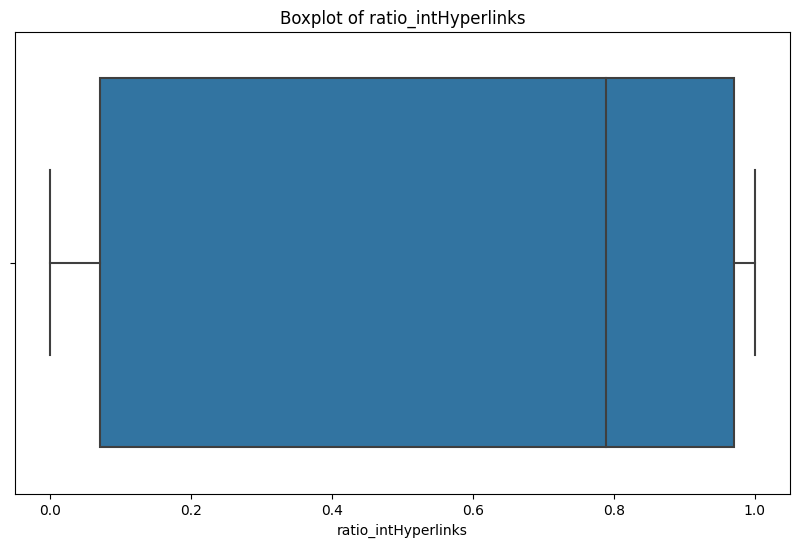

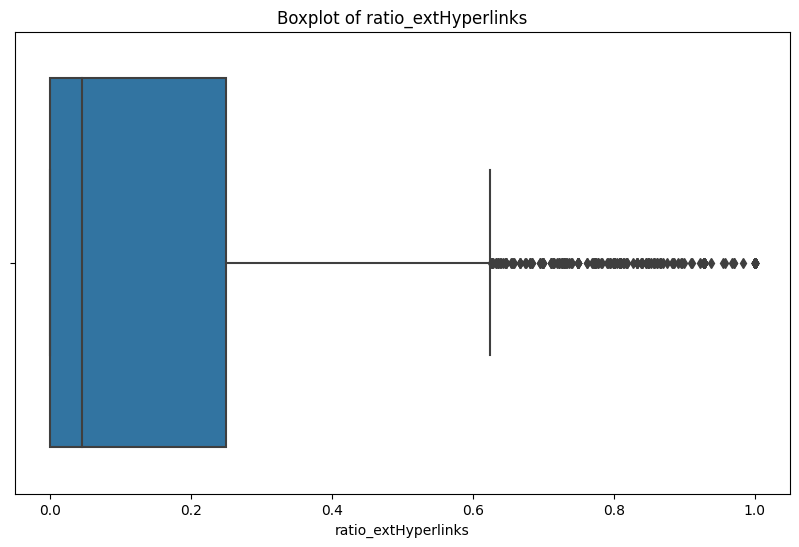

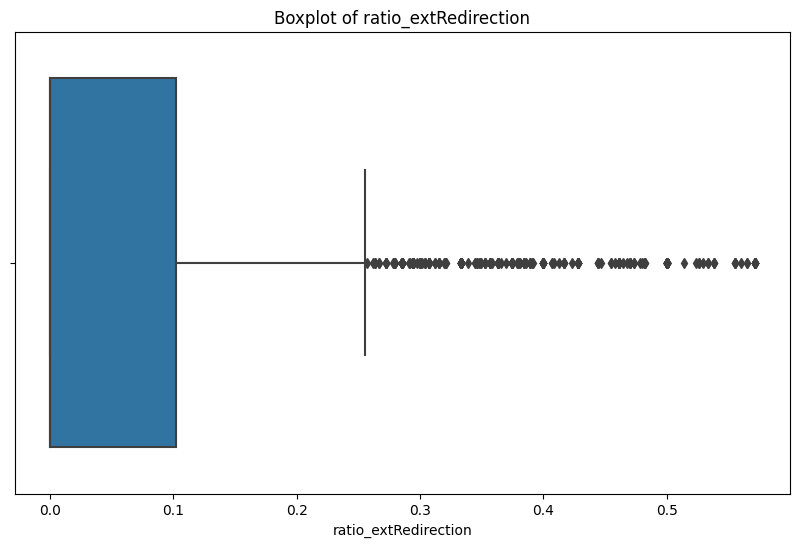

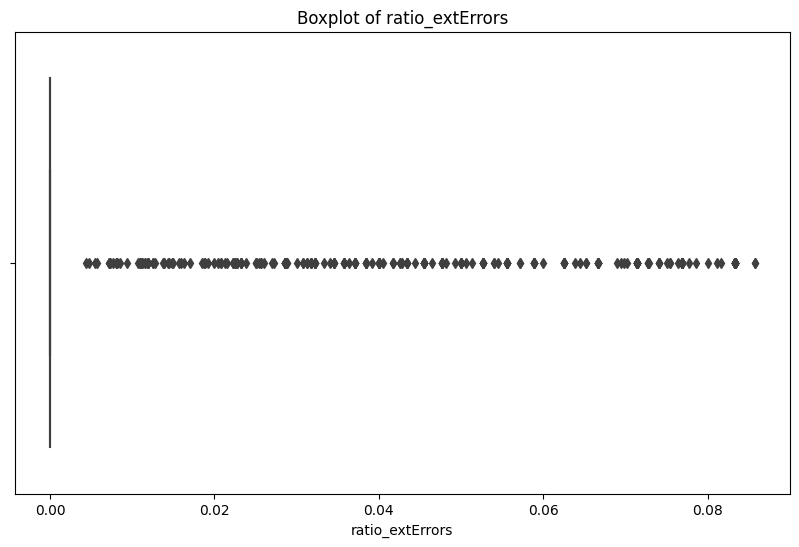

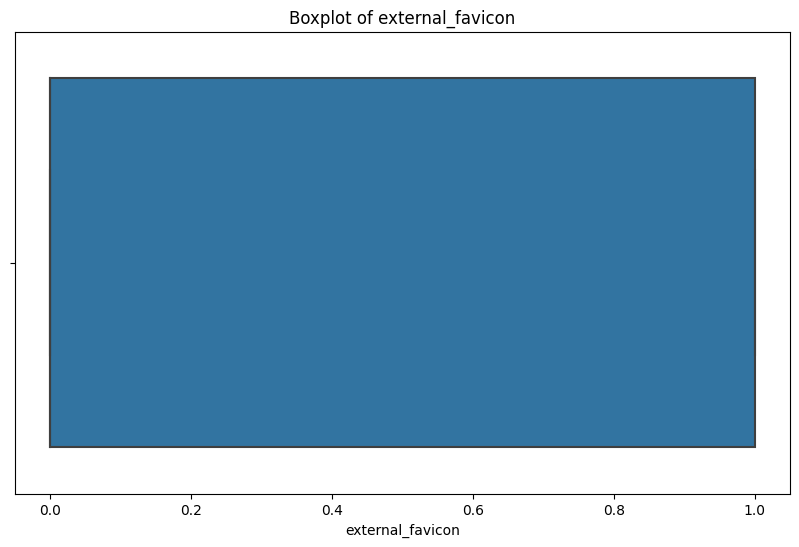

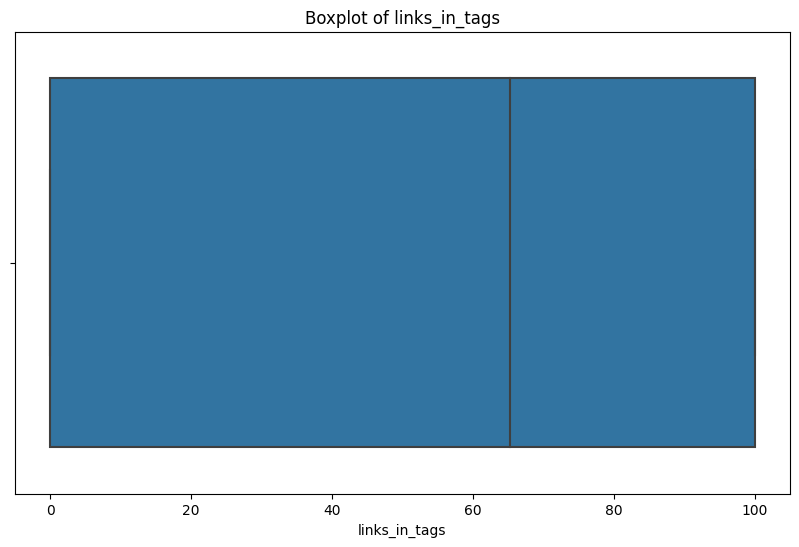

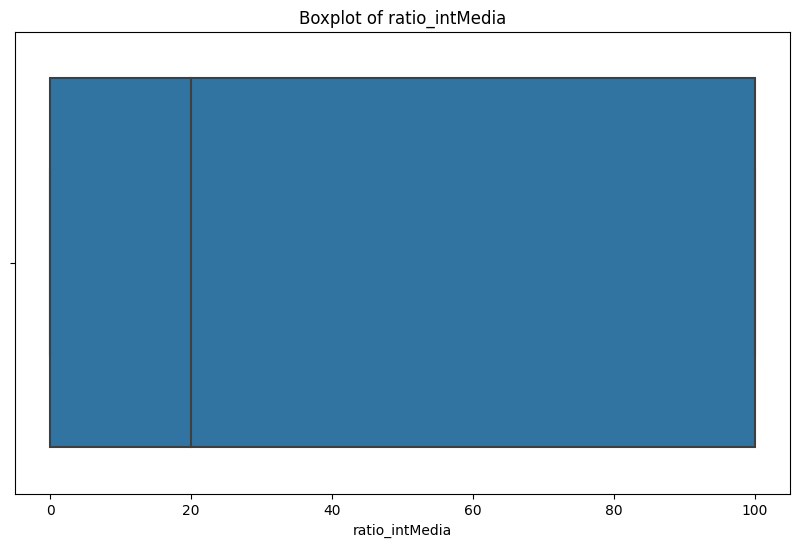

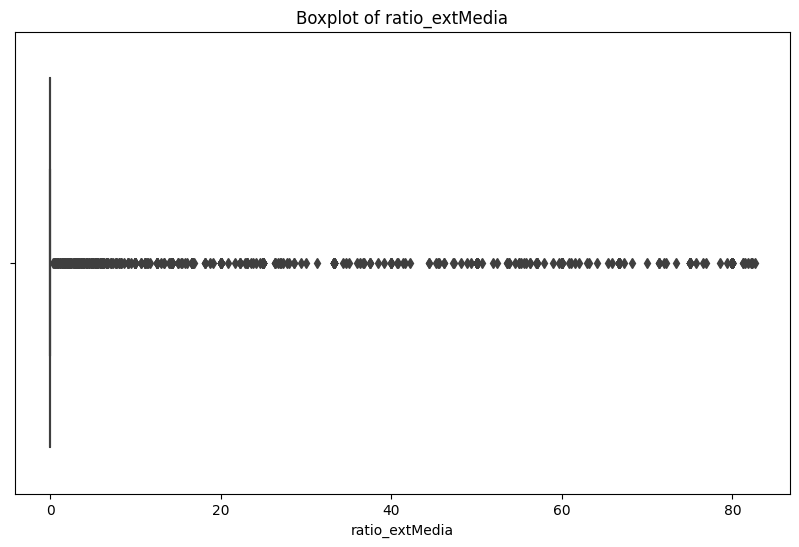

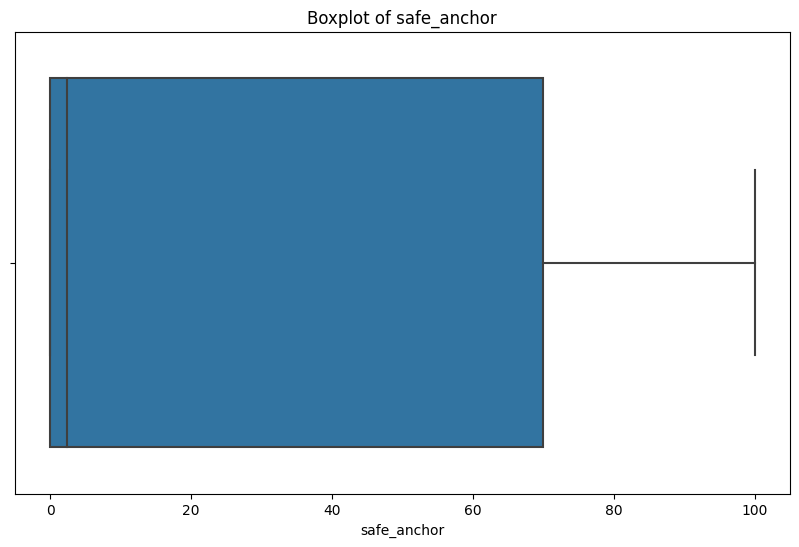

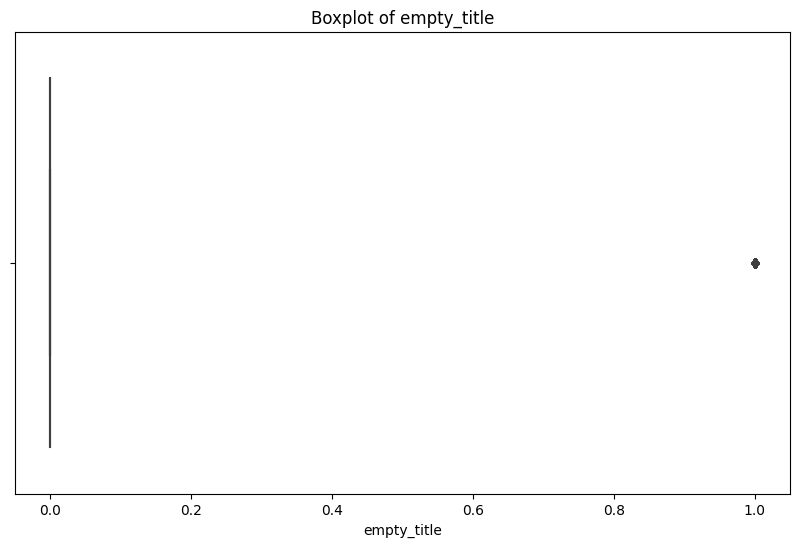

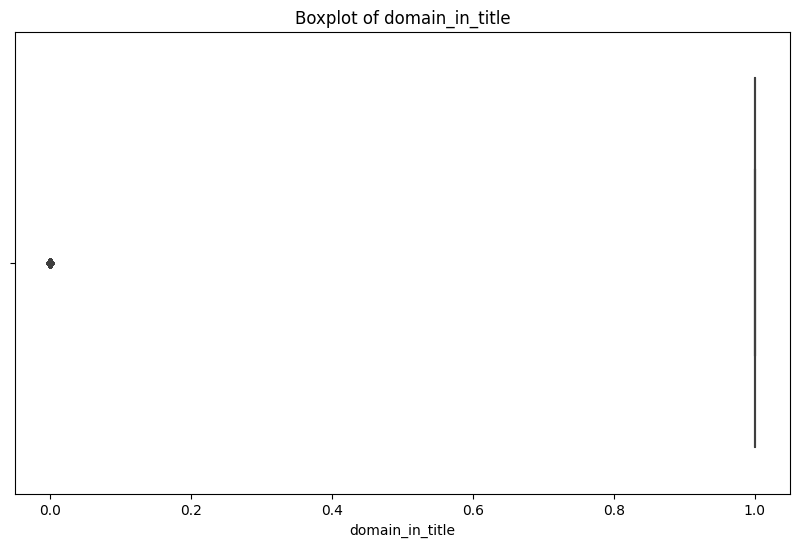

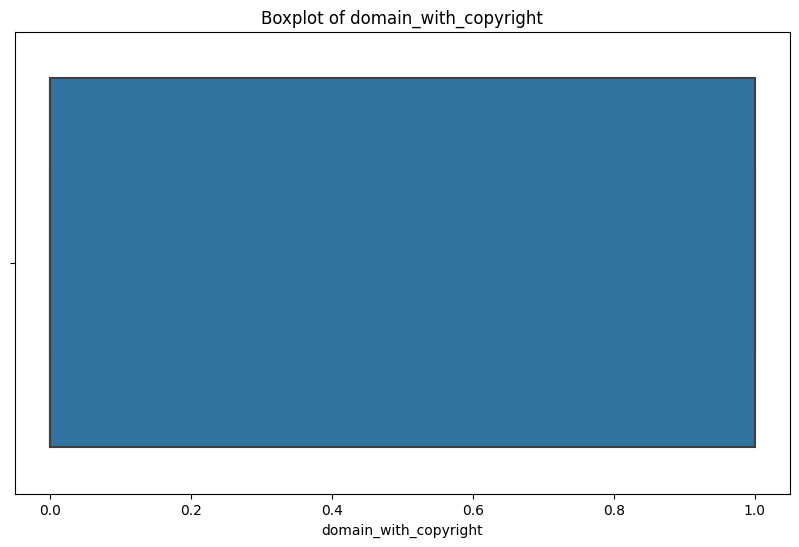

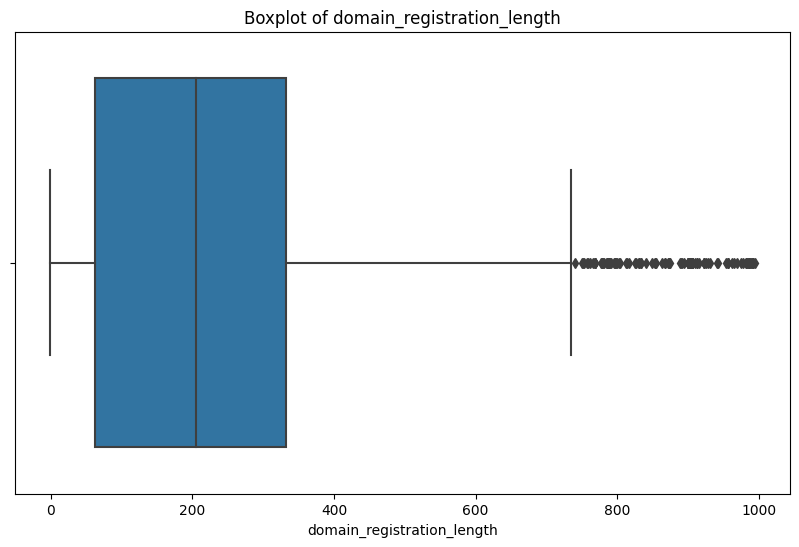

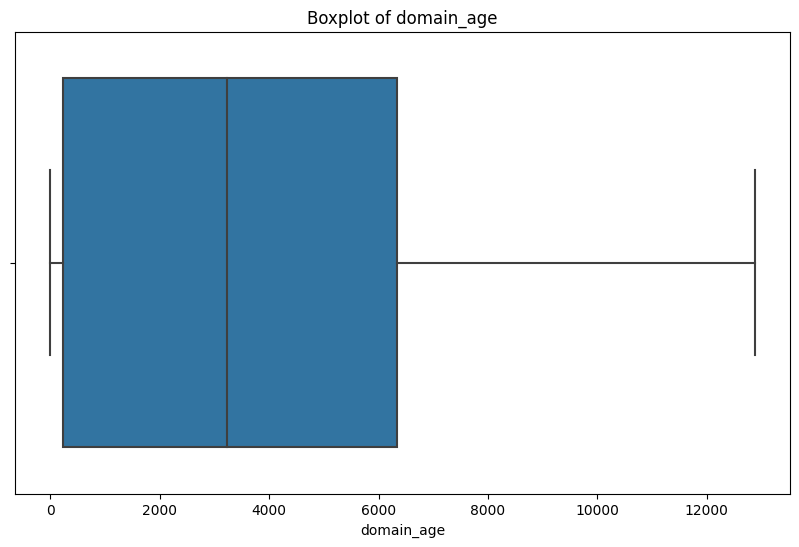

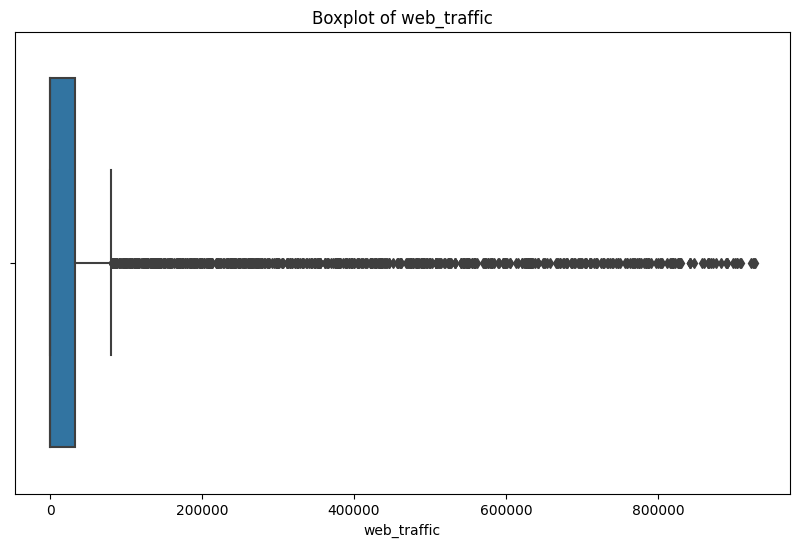

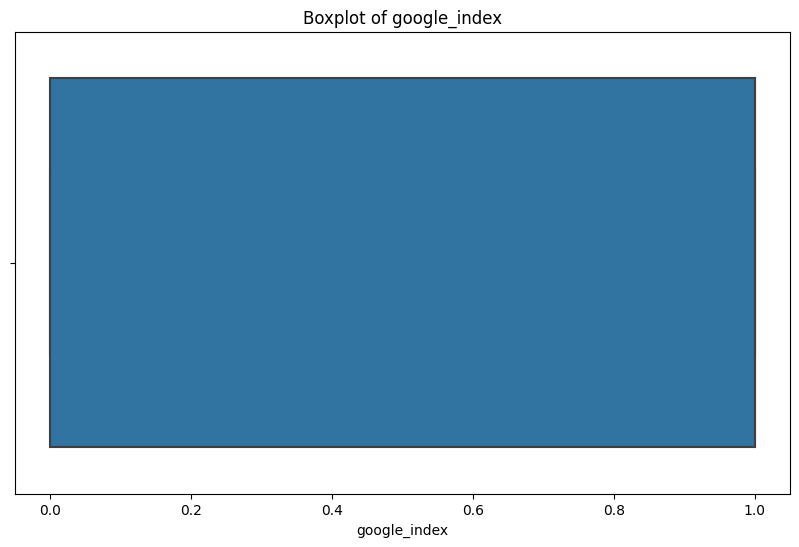

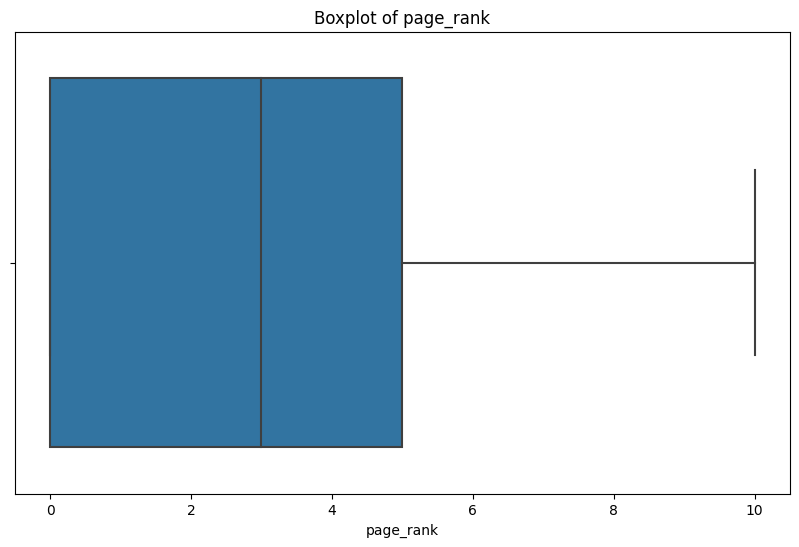

In [22]:
# Boxplot for numerical features
def box_plot_column(column, column_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column)
    plt.title(f"Boxplot of {column_name}")
    plt.show()

# Loop through each numerical column
for column in prim_cleaned_df[numerical_cols]:
    box_plot_column(prim_cleaned_df[numerical_cols][column], column)

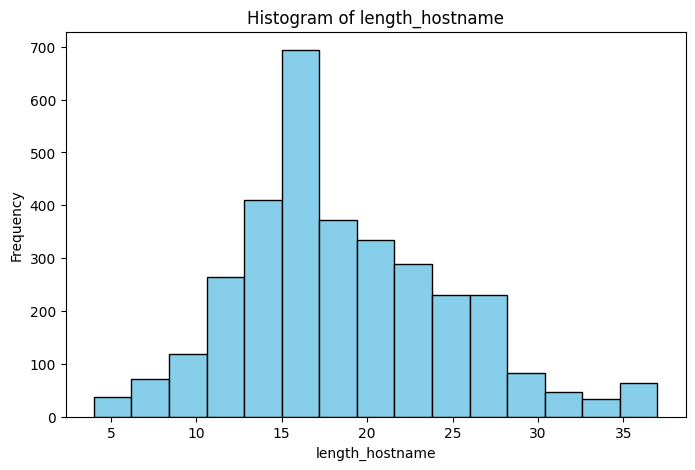

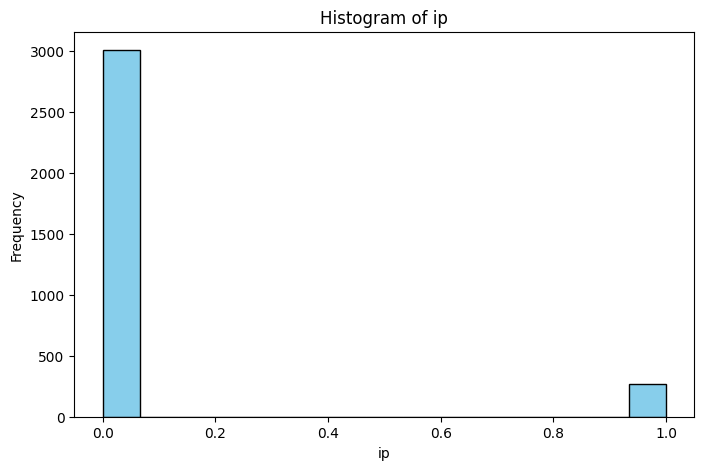

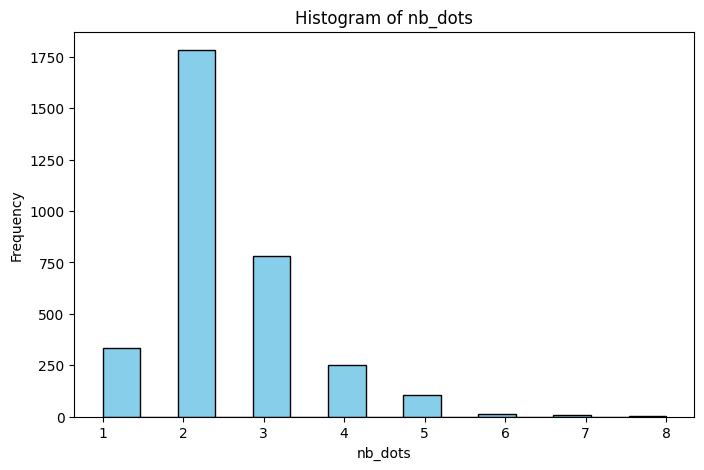

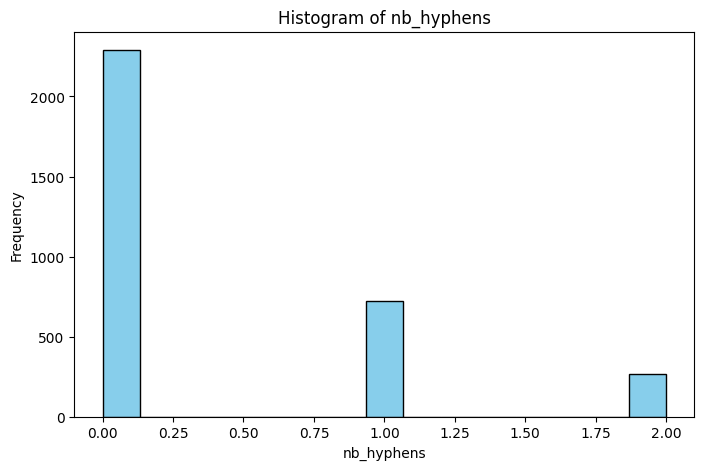

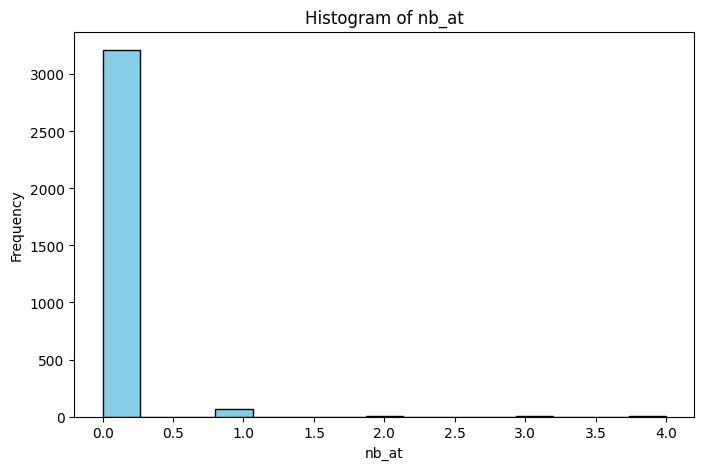

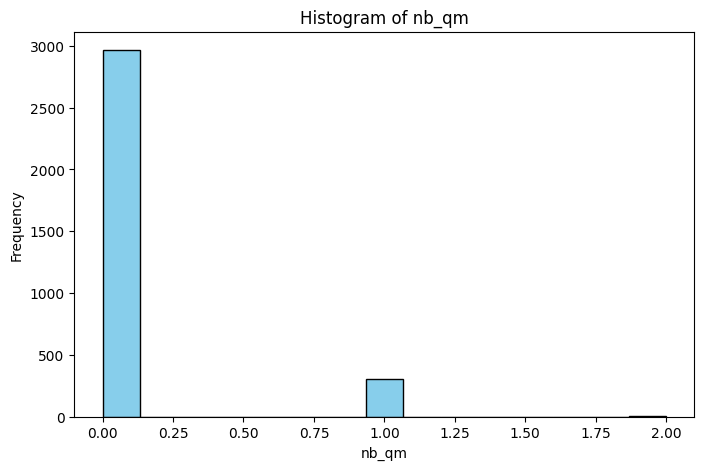

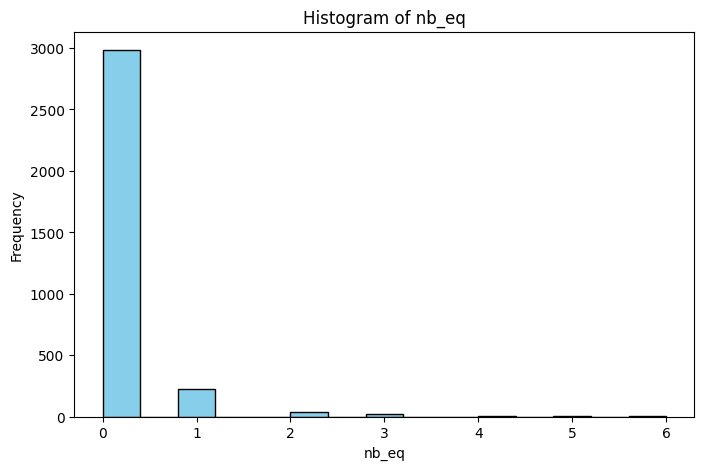

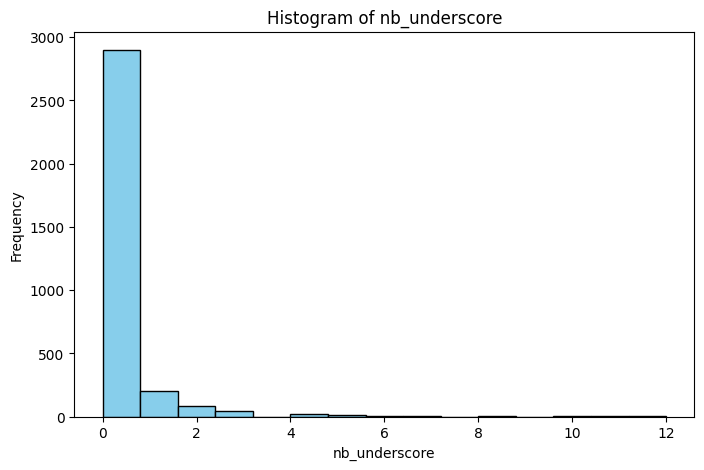

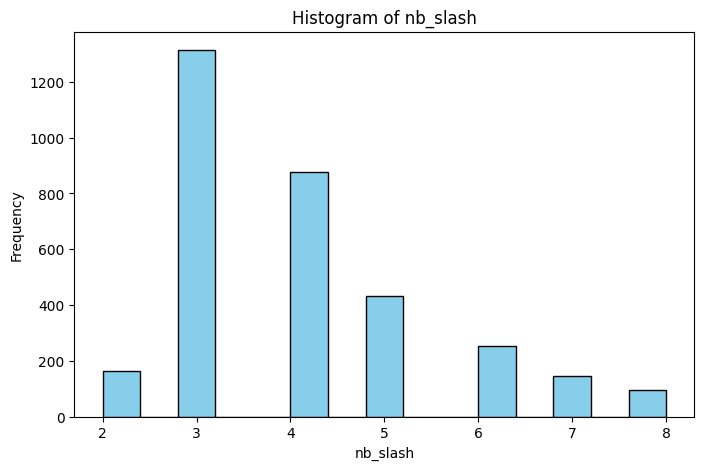

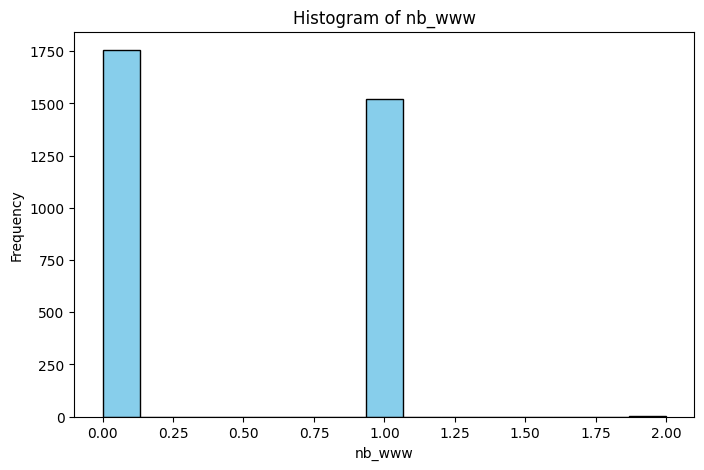

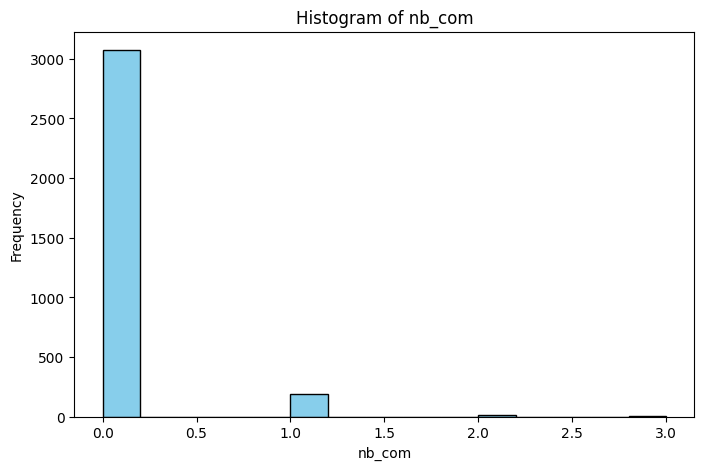

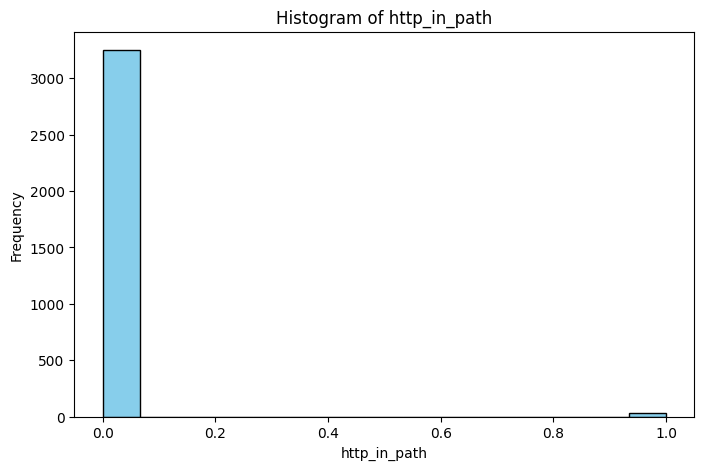

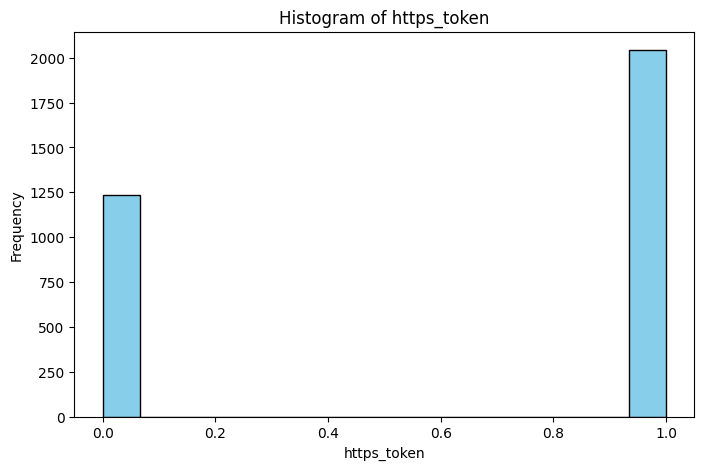

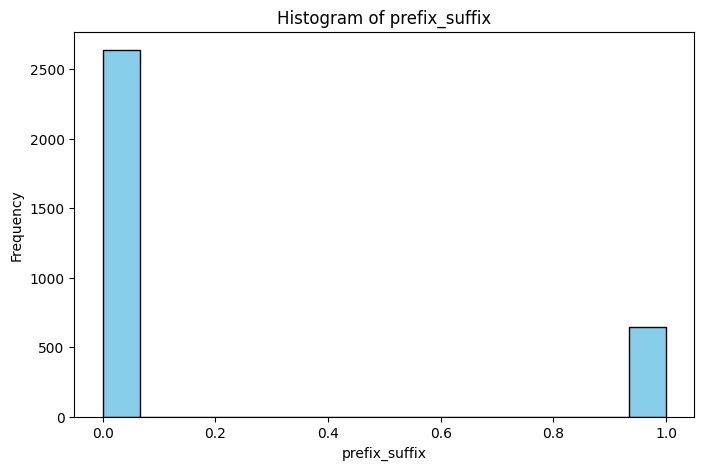

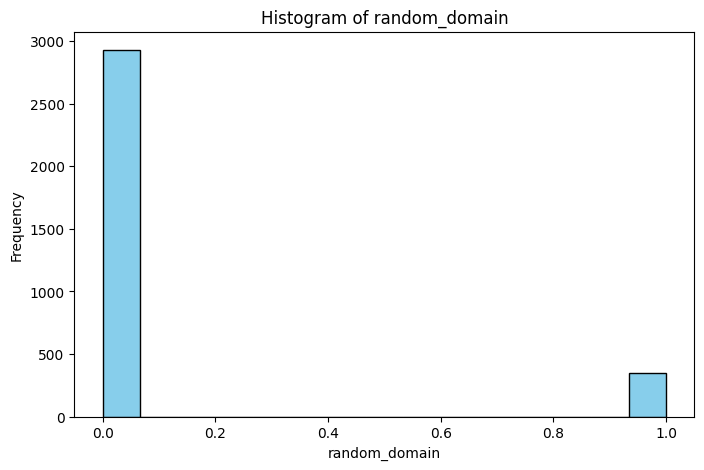

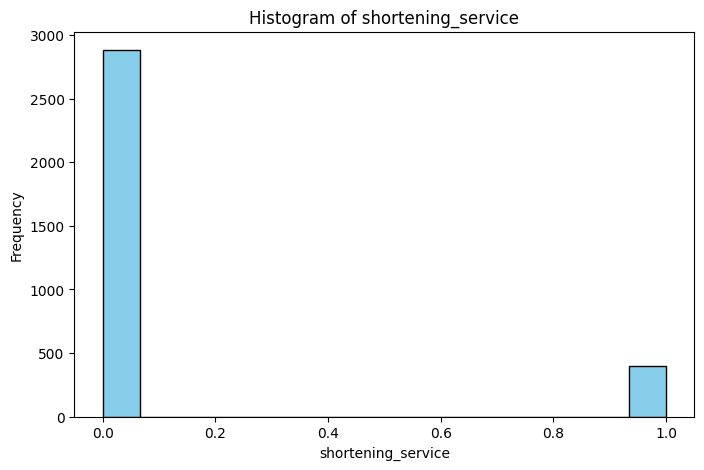

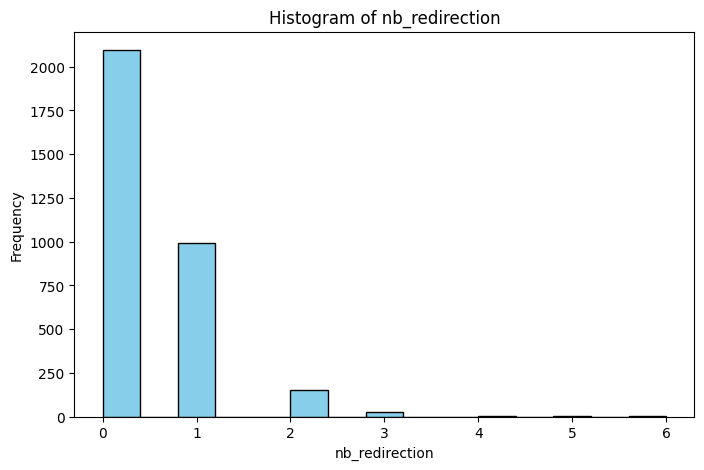

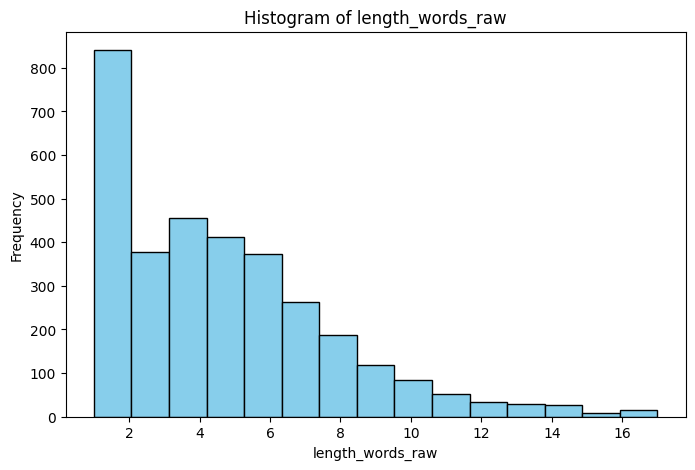

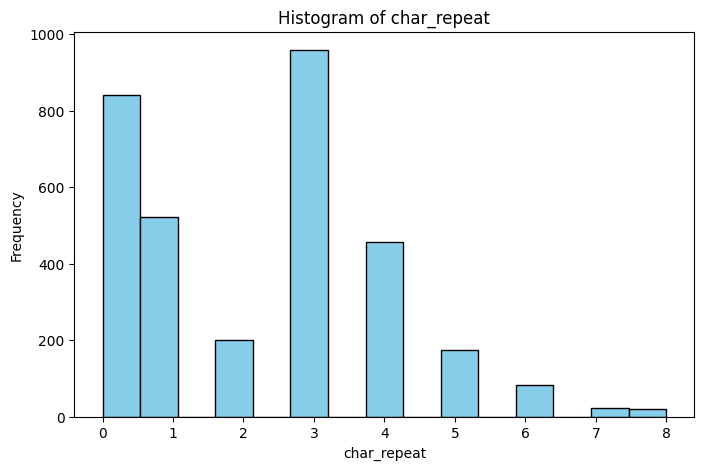

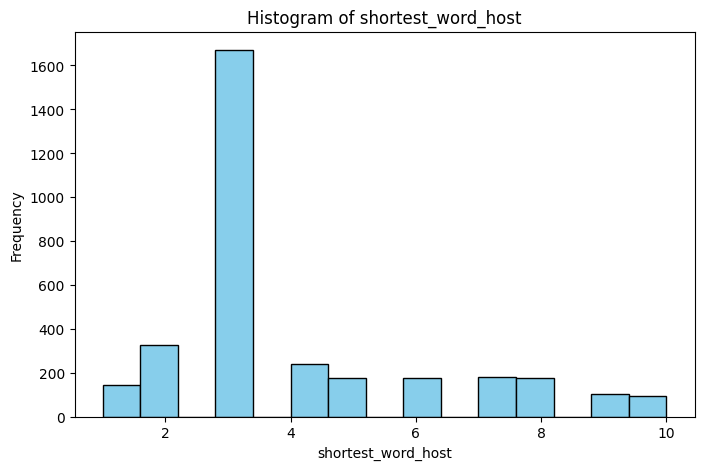

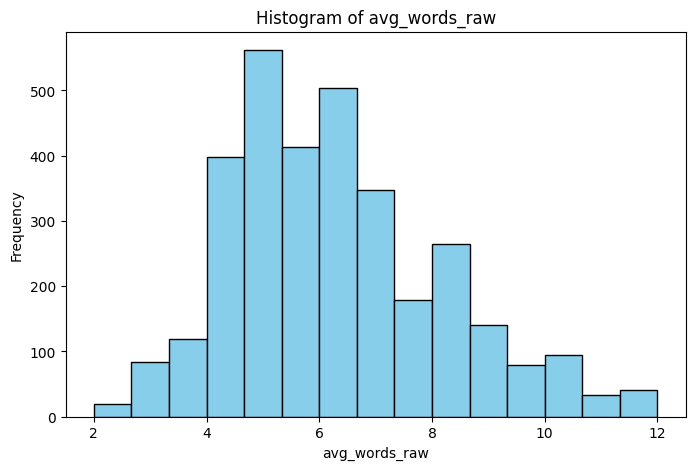

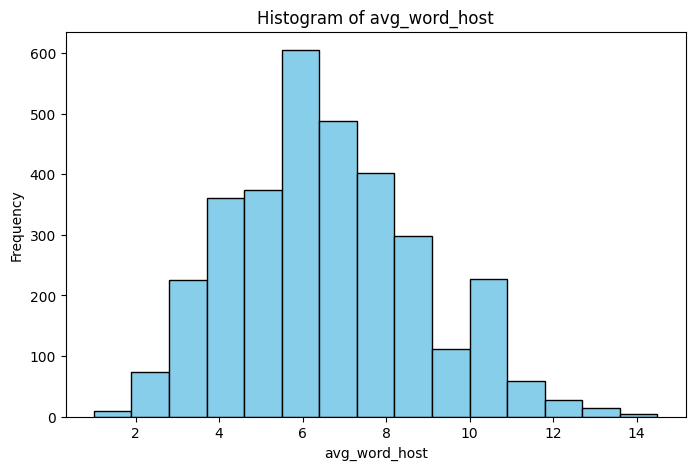

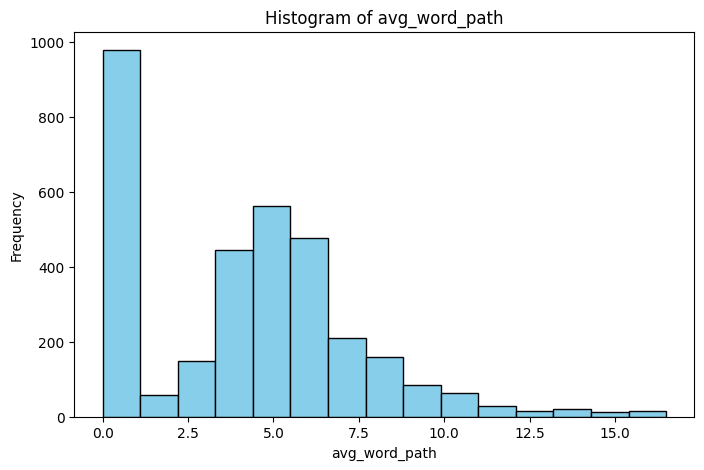

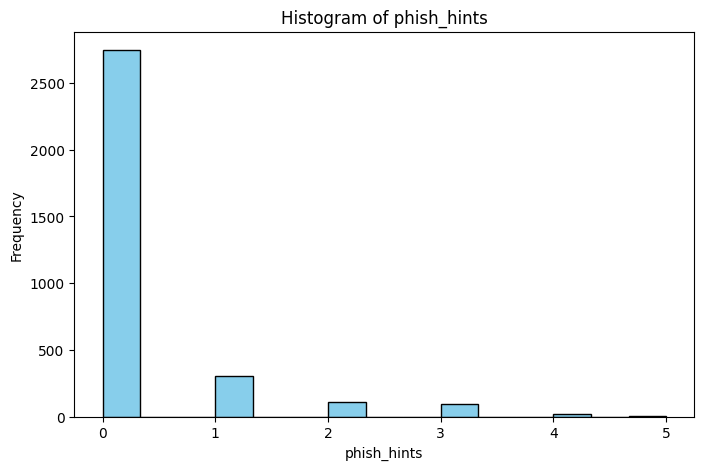

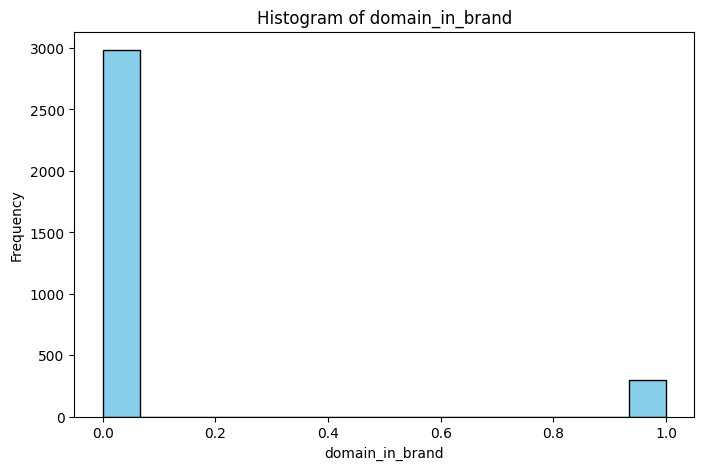

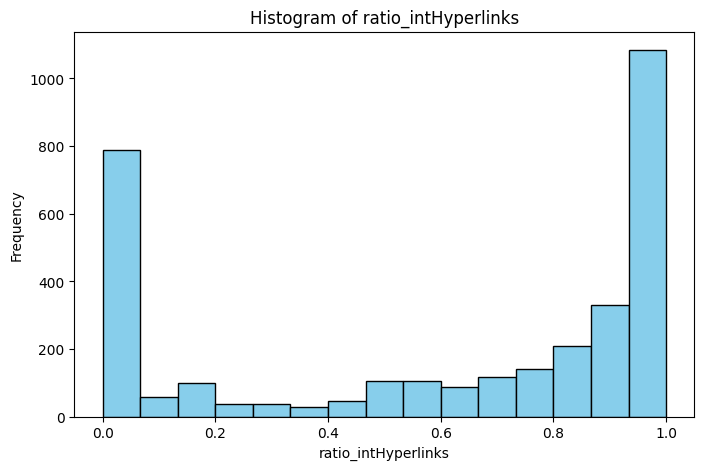

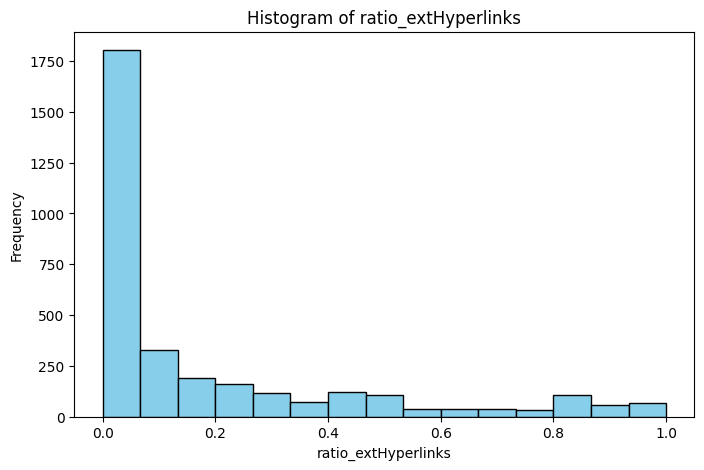

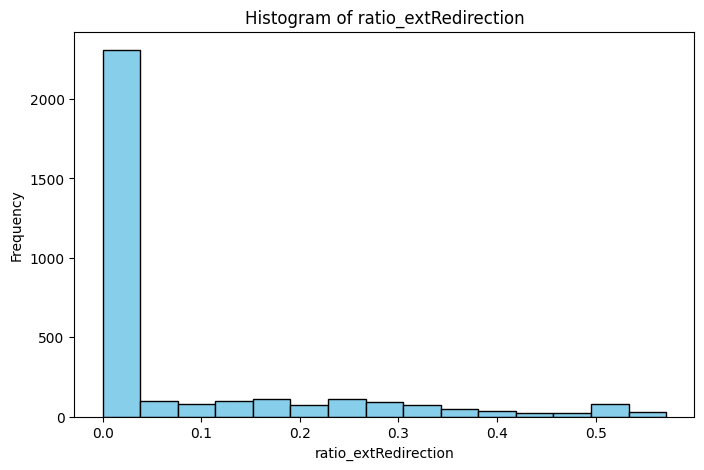

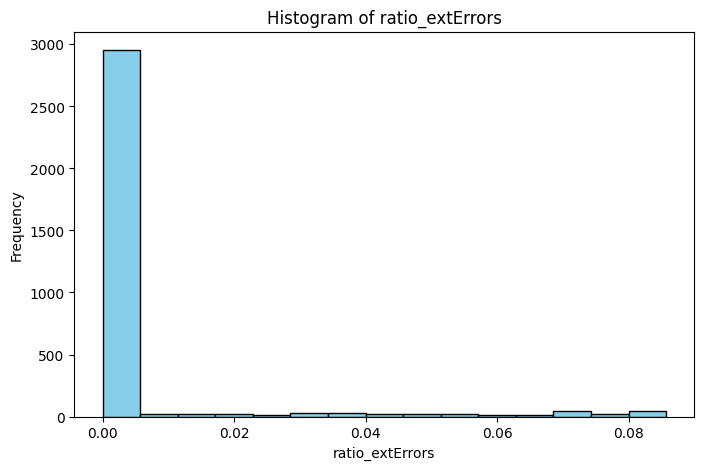

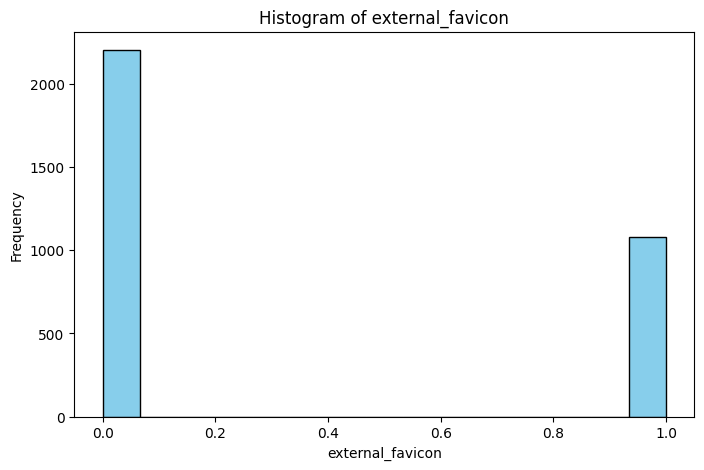

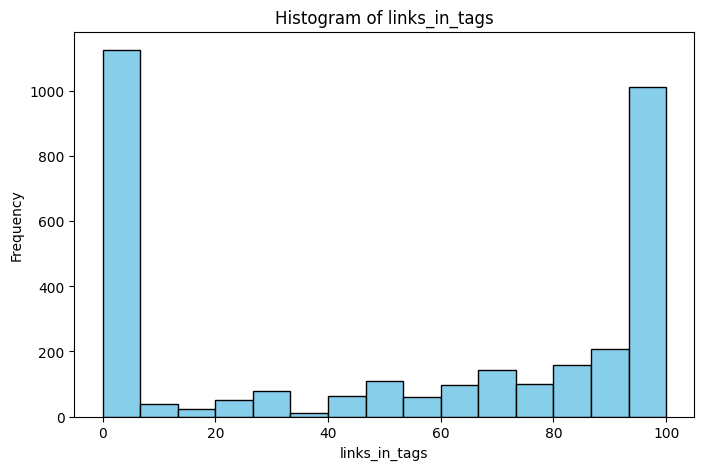

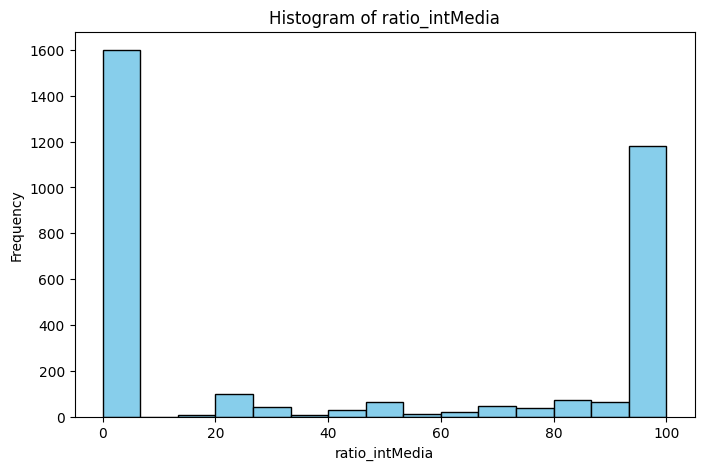

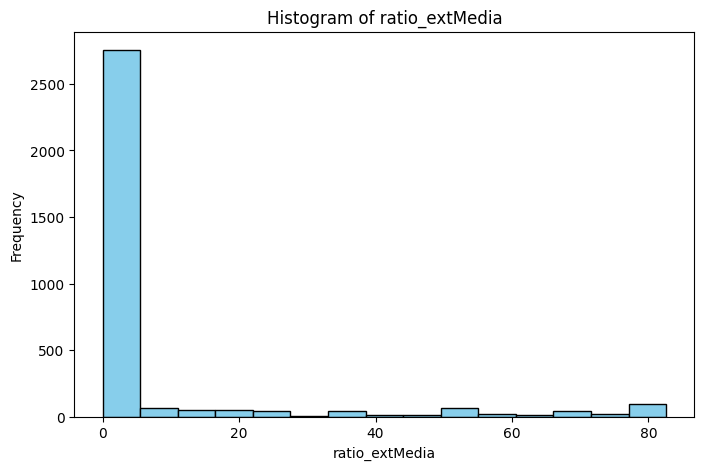

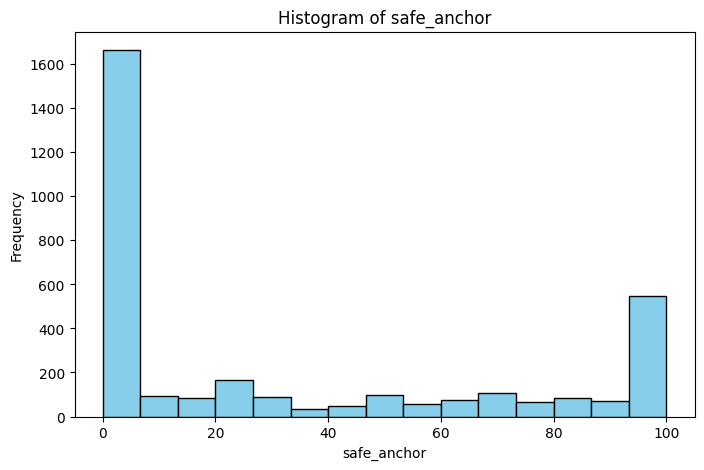

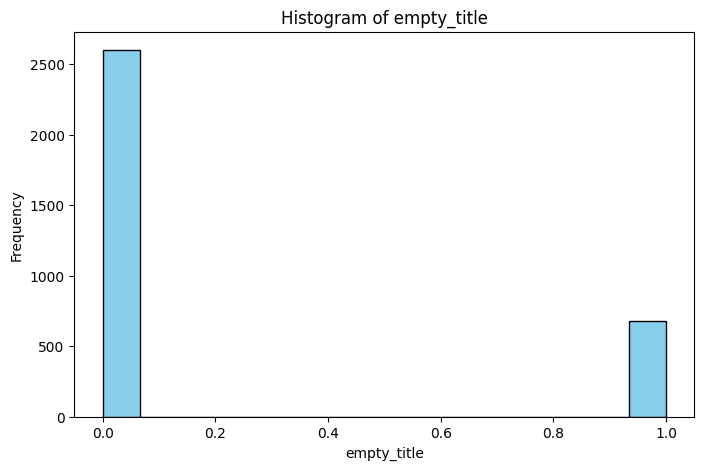

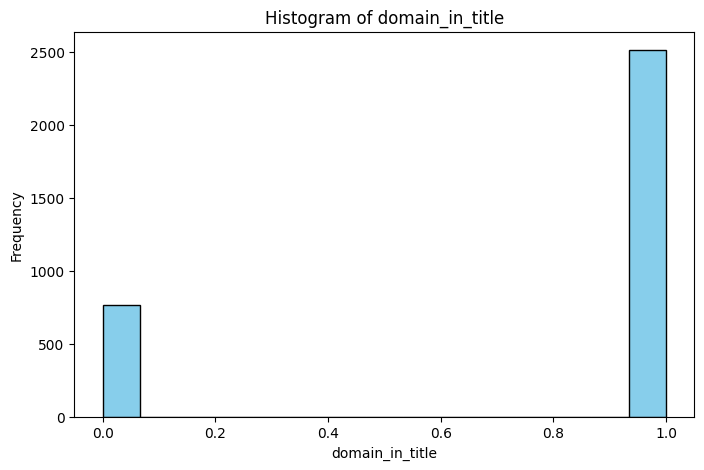

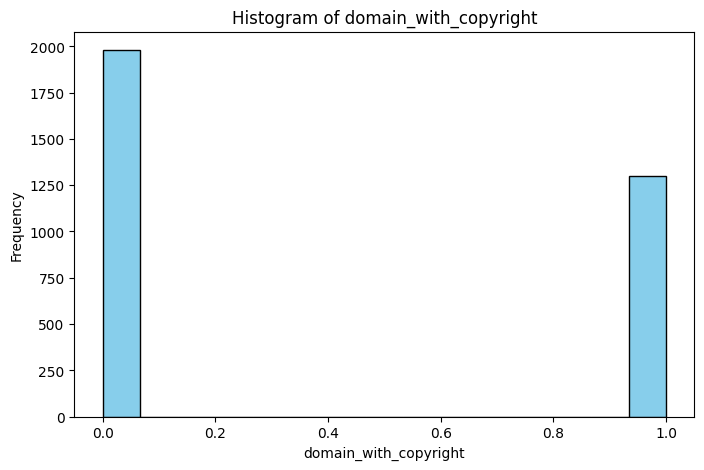

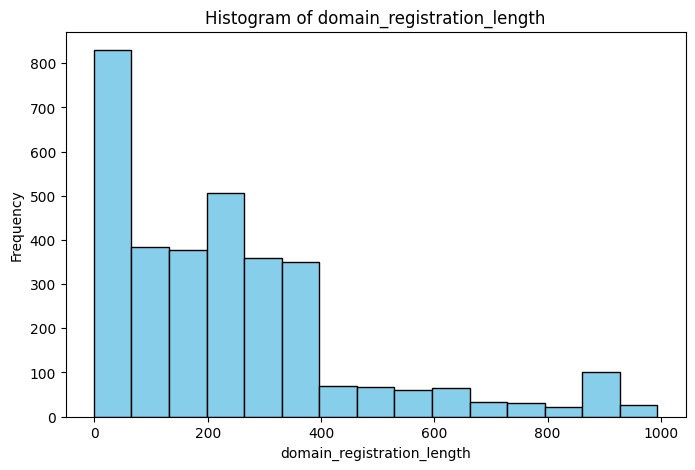

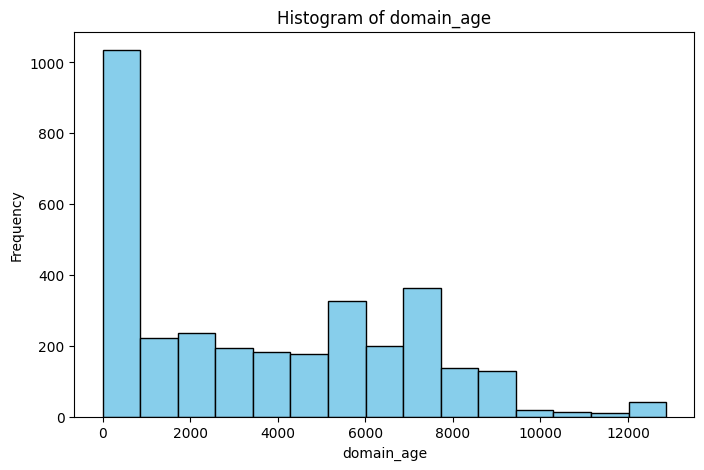

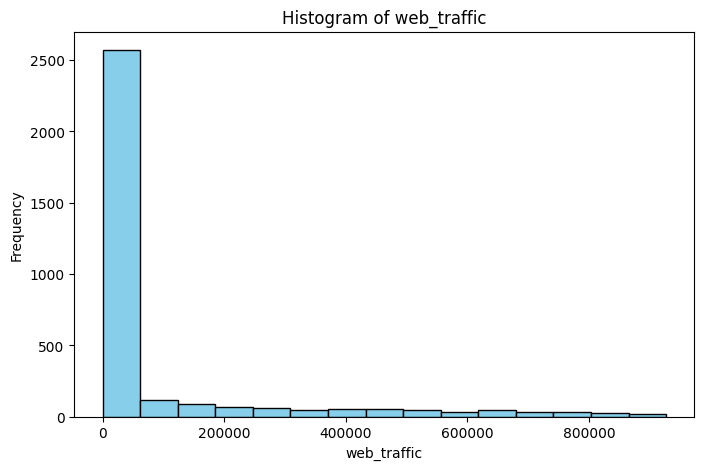

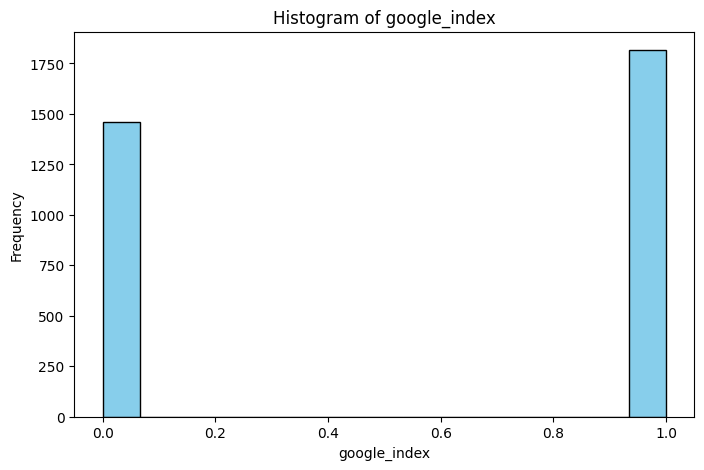

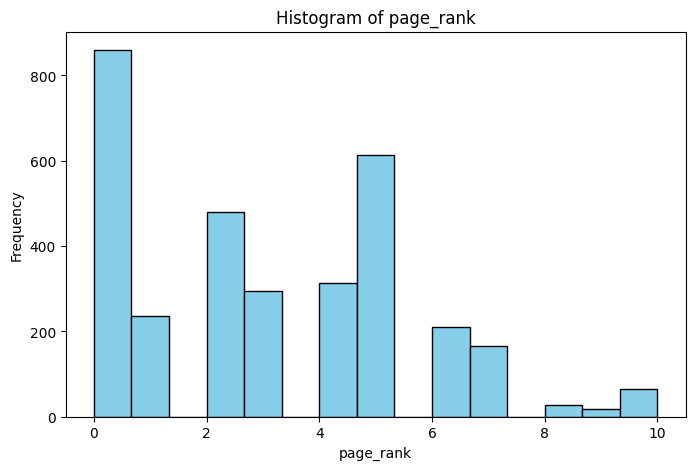

In [23]:
# Define function to plot histograms for all numerical columns
def hist_plot_columns():
    for col in numerical_cols:  # Loop through each numerical column
        plt.figure(figsize=(8, 5))  # Set figure size for each histogram
        plt.hist(prim_cleaned_df[col], bins=15, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col}')  # Dynamic title
        plt.xlabel(col)  # X-axis label
        plt.ylabel('Frequency')  # Y-axis label
        plt.show()  # Display the plot

# Call the function to plot all histograms
hist_plot_columns()

Models

In [24]:
def forward_selection(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    best_features = []
    
    while remaining_features:
        p_values = []
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [feature]])).fit()
            p_values.append((feature, model.pvalues[feature]))
        
        # Select the feature with the lowest p-value that is below the significance level
        feature, p_value = min(p_values, key=lambda x: x[1])
        if p_value < significance_level:
            initial_features.append(feature)
            remaining_features.remove(feature)
            best_features.append(feature)
            print(f"Added {feature} with p-value {p_value:.4f}")
        else:
            break
    
    return best_features


predictors = prim_cleaned_df.drop(columns=['web_traffic','status','url']).columns
X = prim_cleaned_df[predictors]
y = prim_cleaned_df['web_traffic']

# Log-transform the target to handle skewness
y = np.log1p(y)

# Add a constant for the intercept
X = sm.add_constant(X)

# Run forward selection for Linear Regression
selected_features_linear = forward_selection(X, y)
print("Selected features for linear regression:", selected_features_linear)

Added const with p-value 0.0000
Added page_rank with p-value 0.0000
Added domain_in_brand with p-value 0.0000
Added google_index with p-value 0.0000
Added ratio_intHyperlinks with p-value 0.0000
Added phish_hints with p-value 0.0000
Added shortening_service with p-value 0.0000
Added avg_word_path with p-value 0.0000
Added safe_anchor with p-value 0.0001
Added ratio_intMedia with p-value 0.0002
Added shortest_word_host with p-value 0.0002
Added nb_www with p-value 0.0002
Added random_domain with p-value 0.0002
Added ratio_extRedirection with p-value 0.0012
Added ratio_extHyperlinks with p-value 0.0022
Added avg_word_host with p-value 0.0055
Added avg_words_raw with p-value 0.0007
Added domain_age with p-value 0.0058
Added char_repeat with p-value 0.0130
Added links_in_tags with p-value 0.0147
Added domain_in_title with p-value 0.0220
Added nb_at with p-value 0.0296
Added nb_dots with p-value 0.0102
Added nb_redirection with p-value 0.0280
Selected features for linear regression: ['const

In [25]:
def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while len(features) > 0:
        model = sm.OLS(y, sm.add_constant(X[features])).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print(f"Removed {excluded_feature} with p-value {max_p_value:.4f}")
        else:
            break
    
    return features

# Run backward elimination for Linear Regression
selected_features_backward = backward_elimination(X, y)
print("Selected features for linear regression:", selected_features_backward)

Removed nb_slash with p-value 0.9386
Removed nb_hyphens with p-value 0.9123
Removed domain_registration_length with p-value 0.8570
Removed empty_title with p-value 0.8345
Removed ratio_extErrors with p-value 0.7961
Removed ip with p-value 0.5952
Removed nb_eq with p-value 0.4779
Removed nb_qm with p-value 0.3679
Removed https_token with p-value 0.2030
Removed length_hostname with p-value 0.1661
Removed ratio_extMedia with p-value 0.1214
Removed nb_com with p-value 0.1056
Removed http_in_path with p-value 0.1065
Removed prefix_suffix with p-value 0.1244
Removed length_words_raw with p-value 0.0807
Removed nb_underscore with p-value 0.0852
Removed domain_with_copyright with p-value 0.0679
Removed external_favicon with p-value 0.0758
Selected features for linear regression: ['const', 'nb_dots', 'nb_at', 'nb_www', 'random_domain', 'shortening_service', 'nb_redirection', 'char_repeat', 'shortest_word_host', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',

In [26]:
# Convert to sets for comparison
forward_set = set(selected_features_linear)
backward_set = set(selected_features_backward)

# Find differences
only_in_forward = forward_set - backward_set
only_in_backward = backward_set - forward_set

# Print the results
print("Columns selected only in forward selection:")
for col in only_in_forward:
    print(f"- {col} (Forward)")

print("\nColumns selected only in backward elimination:")
for col in only_in_backward:
    print(f"- {col} (Backward)")

# Combined summary
print("\nComparison summary:")
print(f"Forward selection picked {len(selected_features_linear)} columns: {selected_features_linear}")
print(f"Backward elimination picked {len(selected_features_backward)} columns: {selected_features_backward}")
print(f"Columns common to both methods: {len(forward_set & backward_set)} columns: {forward_set & backward_set}")

Columns selected only in forward selection:

Columns selected only in backward elimination:

Comparison summary:
Forward selection picked 24 columns: ['const', 'page_rank', 'domain_in_brand', 'google_index', 'ratio_intHyperlinks', 'phish_hints', 'shortening_service', 'avg_word_path', 'safe_anchor', 'ratio_intMedia', 'shortest_word_host', 'nb_www', 'random_domain', 'ratio_extRedirection', 'ratio_extHyperlinks', 'avg_word_host', 'avg_words_raw', 'domain_age', 'char_repeat', 'links_in_tags', 'domain_in_title', 'nb_at', 'nb_dots', 'nb_redirection']
Backward elimination picked 24 columns: ['const', 'nb_dots', 'nb_at', 'nb_www', 'random_domain', 'shortening_service', 'nb_redirection', 'char_repeat', 'shortest_word_host', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'links_in_tags', 'ratio_intMedia', 'safe_anchor', 'domain_in_title', 'domain_age', 'google_index', 'page_rank']
Columns 

We can see that both forward and backward selection came up to the same set of columns.
We use these columns to make a linear regression model and make predictions.

                            OLS Regression Results                            
Dep. Variable:            web_traffic   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     76.60
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          1.22e-262
Time:                        23:18:31   Log-Likelihood:                -6473.6
No. Observations:                2295   AIC:                         1.300e+04
Df Residuals:                    2271   BIC:                         1.313e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.5692 

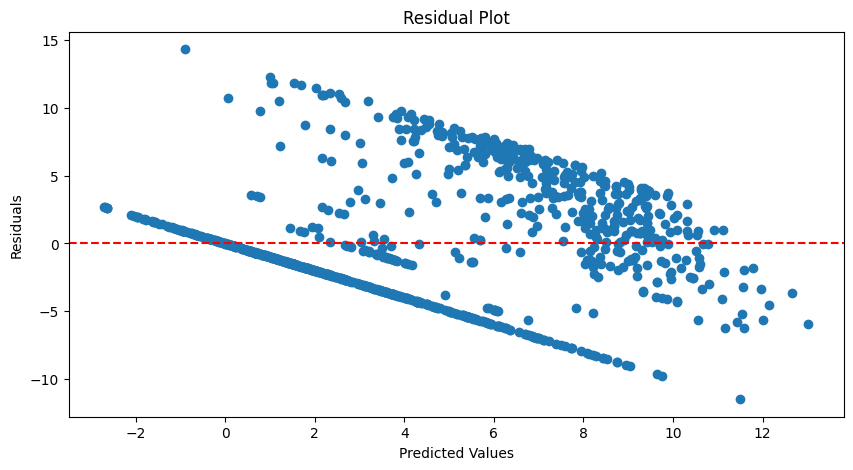

RMSE: 4.2176936526246696
R-squared: 0.39363586064843936
Confidence intervals:
                             0         1
const                 0.478407  2.659927
page_rank             0.973947  1.173013
domain_in_brand      -8.450276 -6.976326
google_index         -1.792859 -0.862880
ratio_intHyperlinks   0.558825  2.350402
phish_hints          -0.821480 -0.334922
shortening_service   -1.561365 -0.358023
avg_word_path        -0.218100 -0.093885
safe_anchor          -0.014216 -0.004191
ratio_intMedia        0.002670  0.011803
shortest_word_host    0.208413  0.429970
nb_www                0.466237  1.629800
random_domain         0.329060  1.476629
ratio_extRedirection  0.662386  3.419305
ratio_extHyperlinks  -2.107011 -0.578728
avg_word_host        -0.432556 -0.174802
avg_words_raw         0.117587  0.395149
domain_age            0.000062  0.000193
char_repeat          -0.297437  0.004651
links_in_tags        -0.015870 -0.000645
domain_in_title      -1.045930 -0.121273
nb_at               

In [29]:
# Select relevant predictors (example)
predictors = selected_features_linear
# predictors = predictors.remove('const')
X = prim_cleaned_df[predictors]
y = prim_cleaned_df['web_traffic']

# Log-transform the target to handle skewness (Box-Cox can also be applied)
y = np.log1p(y)

# Add a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test)

# Residual plots
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# Confidence intervals for coefficients
print("Confidence intervals:")
print(model.conf_int())

We found that after runnning the model we only had a R-sqr value of 0.3936. This means that only 39.36% of the variation in the predicted value was explained by our models predictors. This means its a relatively weak model and we must either add or remove features inorder to get a better model.

In [30]:
# Re initializing and Dropping less Columns:
dropped_columns = ["nb_subdomains"]

print(f"Number of Columns dropped: {len(dropped_columns)}")
reduced_df = base_df.drop(columns=dropped_columns)
print(f"Reduced Dataframe Shape: Rows = {reduced_df.shape[0]} Columns = {reduced_df.shape[1]}")

# Selecting numerical values and dropping any outliers:
numerical_cols = reduced_df.select_dtypes(include=np.number).columns
# Identify numerical columns that are not binary
non_binary_cols = [col for col in numerical_cols if reduced_df[col].nunique() > 20]

# Calculate Q1, Q3, and IQR for non-binary columns
Q1 = reduced_df[non_binary_cols].quantile(0.25)
Q3 = reduced_df[non_binary_cols].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers for non-binary numerical columns
prim_cleaned_df_all_cols = reduced_df[~((reduced_df[non_binary_cols] < (Q1 - 1.5 * IQR)) | (reduced_df[non_binary_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

Number of Columns dropped: 1
Reduced Dataframe Shape: Rows = 11430 Columns = 88


In [31]:
predictors = prim_cleaned_df_all_cols.drop(columns=['web_traffic','status','url']).columns
X = prim_cleaned_df_all_cols[predictors]
y = prim_cleaned_df_all_cols['web_traffic']

# Log-transform the target to handle skewness
y = np.log1p(y)

# Add a constant for the intercept
X = sm.add_constant(X)

# Run forward selection for Linear Regression
selected_features_linear_all_cols = forward_selection(X, y)
print("Selected features for linear regression:", selected_features_linear_all_cols)

Added const with p-value 0.0000
Added google_index with p-value 0.0000
Added page_rank with p-value 0.0000
Added domain_in_brand with p-value 0.0000
Added ratio_intMedia with p-value 0.0000
Added dns_record with p-value 0.0000
Added phish_hints with p-value 0.0004
Added random_domain with p-value 0.0003
Added suspecious_tld with p-value 0.0053
Added ratio_extRedirection with p-value 0.0048
Added http_in_path with p-value 0.0074
Added nb_redirection with p-value 0.0135
Added whois_registered_domain with p-value 0.0160
Added domain_age with p-value 0.0074
Added nb_slash with p-value 0.0325
Added nb_underscore with p-value 0.0202
Added longest_word_host with p-value 0.0323
Selected features for linear regression: ['const', 'google_index', 'page_rank', 'domain_in_brand', 'ratio_intMedia', 'dns_record', 'phish_hints', 'random_domain', 'suspecious_tld', 'ratio_extRedirection', 'http_in_path', 'nb_redirection', 'whois_registered_domain', 'domain_age', 'nb_slash', 'nb_underscore', 'longest_wor

                            OLS Regression Results                            
Dep. Variable:            web_traffic   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     85.21
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          3.64e-197
Time:                        23:19:17   Log-Likelihood:                -4241.6
No. Observations:                1518   AIC:                             8517.
Df Residuals:                    1501   BIC:                             8608.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

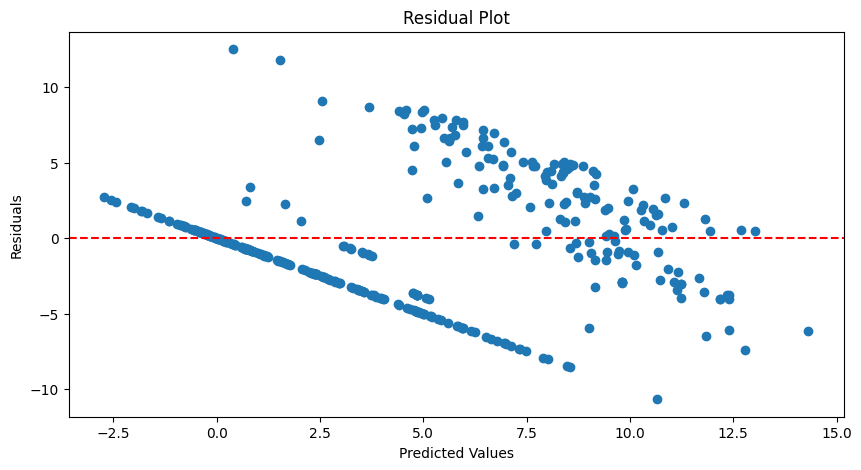

RMSE: 3.8578743511946687
R-squared: 0.4975974392072554
Confidence intervals:
                                 0         1
const                     2.304820  4.404973
google_index             -2.780337 -1.734555
page_rank                 1.001348  1.252761
domain_in_brand         -10.503900 -8.499711
ratio_intMedia            0.004768  0.014002
dns_record                1.248829  5.228612
phish_hints              -0.665404 -0.058733
random_domain             0.267382  1.666916
suspecious_tld            0.084419  2.961001
ratio_extRedirection      0.897344  4.078742
http_in_path              1.217888  6.073521
nb_redirection            0.103992  0.738404
whois_registered_domain   0.479090  2.048837
domain_age                0.000047  0.000201
nb_slash                 -0.405901 -0.048560
nb_underscore            -0.043862  0.358598
longest_word_host        -0.112521 -0.001236


In [34]:
# Select relevant predictors (example)
predictors = selected_features_linear_all_cols
# predictors = predictors.remove('const')
X = prim_cleaned_df_all_cols[predictors]
y = prim_cleaned_df_all_cols['web_traffic']

# Log-transform the target to handle skewness (Box-Cox can also be applied)
y = np.log1p(y)

# Add a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test)

# Residual plots
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# Confidence intervals for coefficients
print("Confidence intervals:")
print(model.conf_int())

Using forward selection on all valid columns in the base dataset, we were able to decrease the RMSE to 3.8579 and increase R-sqr to 0.4976. That means the predicors are able to explain nearly 50% of the variability in the data. This shows that this dataset can not accurately explain the variability in web traffic but this is understandable as this was dataset was meant to predict status.

Logistic Regression:

In [35]:
le = LabelEncoder()
prim_cleaned_df['status_encoded'] = le.fit_transform(prim_cleaned_df['status'])

predictors = prim_cleaned_df.drop(columns=['status','url']).columns
X_log_status = prim_cleaned_df[predictors]
y_log_Status = prim_cleaned_df['status_encoded']

In order to use logistic regression, we must first make sure there are is no multicolinearity in the data. We will use VIF to remove columns with high collinearirty.

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_log_status.columns
vif_data["VIF"] = [variance_inflation_factor(X_log_status.values, i) for i in range(X_log_status.shape[1])]
print(vif_data[vif_data["VIF"] > 10])  # Features with high multicollinearity

                Feature        VIF
0       length_hostname  40.683148
2               nb_dots  24.649004
8              nb_slash  31.353980
17     length_words_raw  43.836249
19   shortest_word_host  11.888413
20        avg_words_raw  34.021223
21        avg_word_host  47.832319
25  ratio_intHyperlinks  17.798280


In [37]:
print("We remove all columns with high VIF based on reducing multicolinearity: length_hostname,nb_dots,nb_slash,shortest_word_host,ratio_intHyperlinks,avg_word_host, avg_words_raw,length_words_raw")
print("We will check again after dropping these columns for any other VIF")
prim_cleaned_df_log = prim_cleaned_df.drop(columns=["length_hostname","nb_dots","nb_slash","shortest_word_host","ratio_intHyperlinks","avg_word_host", "avg_words_raw","length_words_raw"])

le = LabelEncoder()
prim_cleaned_df_log['status_encoded'] = le.fit_transform(prim_cleaned_df_log['status'])

predictors = prim_cleaned_df_log.drop(columns=['status','url']).columns
X_log_status = prim_cleaned_df_log[predictors]
y_log_Status = prim_cleaned_df_log['status_encoded']
vif_data = pd.DataFrame()
vif_data["Feature"] = X_log_status.columns
vif_data["VIF"] = [variance_inflation_factor(X_log_status.values, i) for i in range(X_log_status.shape[1])]
print(vif_data[vif_data["VIF"] > 10])  # Features with high multicollinearity

We remove all columns with high VIF based on reducing multicolinearity: length_hostname,nb_dots,nb_slash,shortest_word_host,ratio_intHyperlinks,avg_word_host, avg_words_raw,length_words_raw
We will check again after dropping these columns for any other VIF
Empty DataFrame
Columns: [Feature, VIF]
Index: []


Standardizing the values
The values in the dataset are very imbalaced, and it is important to have standardized values to use the logrithmic regression model.

In [38]:
# Select only numerical columns
numerical_cols = prim_cleaned_df_log.select_dtypes(include=['number']).columns

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
prim_cleaned_df_log[numerical_cols] = scaler.fit_transform(prim_cleaned_df_log[numerical_cols])

# Verify the standardization
print(prim_cleaned_df_log[numerical_cols].describe())

                ip    nb_hyphens         nb_at         nb_qm         nb_eq  \
count  3279.000000  3.279000e+03  3.279000e+03  3.279000e+03  3.279000e+03   
mean      0.000000 -3.033729e-17 -2.383644e-17  2.600339e-17  1.408517e-17   
std       1.000153  1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00   
min      -0.298946 -6.059480e-01 -1.322306e-01 -3.215758e-01 -2.636562e-01   
25%      -0.298946 -6.059480e-01 -1.322306e-01 -3.215758e-01 -2.636562e-01   
50%      -0.298946 -6.059480e-01 -1.322306e-01 -3.215758e-01 -2.636562e-01   
75%      -0.298946  9.810356e-01 -1.322306e-01 -3.215758e-01 -2.636562e-01   
max       3.345085  2.568019e+00  2.395577e+01  6.331087e+00  1.220551e+01   

       nb_underscore        nb_www        nb_com  http_in_path   https_token  \
count   3.279000e+03  3.279000e+03  3.279000e+03  3.279000e+03  3.279000e+03   
mean    3.683814e-17  8.776145e-17 -5.634069e-17 -2.058602e-17 -1.446439e-16   
std     1.000153e+00  1.000153e+00  1.000153e+00  1.00015

In [ ]:
def forward_selection_logistic(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    selected_features = []

    while remaining_features:
        p_values = []
        for feature in remaining_features:
            try:
                model = sm.Logit(y, sm.add_constant(X[initial_features + [feature]])).fit(disp=False)
                p_values.append((feature, model.pvalues[feature]))
            except np.linalg.LinAlgError:
                pass
        
        if not p_values:  # Stop if no more valid features
            break
        
        # Select the feature with the lowest p-value
        p_values = sorted(p_values, key=lambda x: x[1])
        best_feature, best_p_value = p_values[0]

        if best_p_value < significance_level:
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            selected_features.append(best_feature)
        else:
            break

    return selected_features

le = LabelEncoder()
prim_cleaned_df_log['status_encoded'] = le.fit_transform(prim_cleaned_df_log['status'])

predictors = prim_cleaned_df_log.drop(columns=['status','url']).columns
X_log_status = prim_cleaned_df_log[predictors]
y_log_Status = prim_cleaned_df_log['status_encoded']


# Run forward selection for Logistic Regression
selected_features_logistic = forward_selection_logistic(X_log_status, y_log_Status)
print("Selected features for logistic regression:", selected_features_logistic)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may n

Selected features for logistic regression: ['google_index', 'page_rank', 'nb_www', 'ip', 'nb_qm']


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detect

In [40]:
print(f"Features selected: {selected_features_logistic}")
print("Selecting specific columns to perform logistic regression.")

X_log_status = X_log_status[selected_features_logistic]

Features selected: ['google_index', 'page_rank', 'nb_www', 'ip', 'nb_qm']
Selecting specific columns to perform logistic regression.


Confusion Matrix:
[[259  41]
 [ 35 321]]


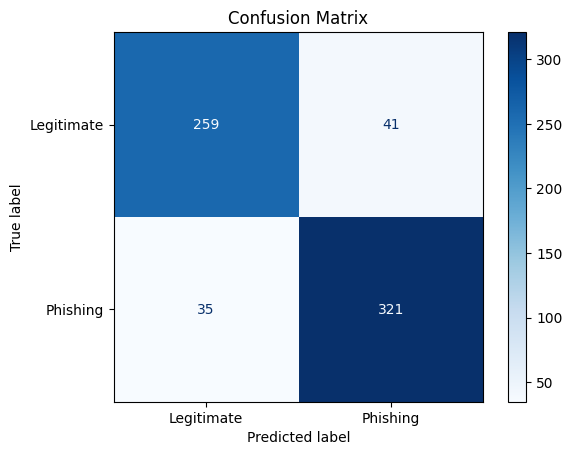

In [41]:
# Example Data (replace with your dataset)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_log_status, y_log_Status, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary class predictions (0 or 1)
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [100]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extract individual confusion matrix values
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Values:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Metrics:
Accuracy: 0.93
Precision: 0.95
Recall: 0.92
F1 Score: 0.93

Confusion Matrix Values:
True Negatives (TN): 282
False Positives (FP): 18
False Negatives (FN): 28
True Positives (TP): 328


As shown by the metrics above, The model is highly accurate in predicting whehter a url is Phishing or legitimate with an accuracy of 93% and a precision of 95%. 